### **Teoretiska frågor:**

**1. Beskriv kort hur en relationsdatabas fungerar.**

En relationsdatabas lagrar data i tabeller som är organiserade i rader och kolumner. Varje rad representerar en post och varje kolumn representerar ett attribut (fält). Tabellerna kopplas sammans med hjälp av relationer, oftast via primär- och främmande nycklar. Dessa nycklar möjliggör att data kan hanteras på ett strukturerat och effektivt sätt.

**2. Vad menas med "CRUD" flödet?**

CRUD är en akronym som står för Create, Read, Update, och Delete, vilket är de fyra grundläggande operationerna för att hantera data i en databas:
* **CREATE**: Lägga till ny data i databasen
* **READ**: Hämta data från databasen
* **UPDATE**: Uppdatera befintlig data.
* **DELETE**: Ta bort data från databasen

**3. Beskriv kort vad en "left join" och en "inner join" är. Varför använder man det?**
   
* **Left Join**: Returnerar alla rader från vänstra tabellen och de matchande raderna från högra tabellen. Om det inte finns någon matchning returneras NULL för kolumner från den högra tabellen. Används när man vill behålla alla poster från vänstra tabellen oavsett matchning.
* **Inner Join**: Returnerar endast rader där det finns en matchning mellan båda tabellerna. Används när man endast behöver data som finns i båda tabellerna.

**4. Vad innebär indexering i SQL?**
   
Indexering innebär att skapa en datastruktur som acchelerar sökningar och sortering i en databas. Ett index är som ett register i en bok och hjälper databashanteraren att snabbt hitta de poster som uppfyller ett visst villkor, vilket förbättrar prestandan vid frågor (queries). Det skapas vanligtvis på kolumner som ofta används i WHERE- eller JOIN-satser.

**5. Vad är en vy i SQL?**
   
En vy är en virtuell tabell som skapas baserat på resultatet av en SQL-query. Den lagrar ina frågorte data själv utan genereras dynamiskt när den används. Vy används för att:
* Förenkla komplex frågor.
* Förbättra säkerheten genom att begränsa åtkomsten till specifika kolumner eller rader.
* Göra det lättare att arbeta med data.

**6. Vad är en lagrad procedur i SQL?**
   
En lagrad procecur är en samlig SQL-queries som sparas i databasen och kan köras som ett program. Den används för att automatisera och optimera återkommande uppgifter, minska nätverkstrafik och säkerställa konsekvent logik. Procedurer stöder parametrar och kan returna resultat eller ändra data i databasen.

## **Sales Analysis of AdventureWork2022**

This project aims to identify valuable insights regarding sales trends and patterns that hopefully will support future business strategies and decision-making. The ultimate goal is to optimize overall sales performance as well as to drive business growth. 

**Business questions**
1. Are there any seasonal patterns or trends in sales?
   
2. Has the total order amount changed over time?

3. How does profit margins change monthly?
   
4. Which country has generated the highest revenue and profit?
   
5. How does each Sales territory contribute to profit margins over time?
   
6. Top 10 products with the highest profit?
   
7. Which product categories have the highest averages sales? And what is the average cost for each category?
   
Tools used for analysis: MSSQL and Python

**Below is the outline for this project:**

1. Data selection and validation
   
2. Data cleaning
   
3. Exploratory Data Analysis + Key Insights
   
4. Inferential Statistic for improving sales
   
5. Executive Summary

In [737]:
import logging
import matplotlib.pyplot as plt
from scipy.stats import skew, skewtest, normaltest
from sqlalchemy import create_engine
from sqlalchemy.exc import OperationalError

import pandas as pd
import numpy as np
from plotnine import (
    ggplot, aes, geom_bar, geom_line, geom_hline, geom_point, geom_area, labs,
    scale_x_datetime, scale_y_continuous, scale_x_discrete,
    scale_color_manual, options, scale_fill_manual, theme, element_rect,
    element_line, element_text, geom_text, coord_flip, element_blank, facet_wrap, position_dodge, geom_histogram, geom_abline, geom_jitter, geom_density, geom_vline, after_stat, 
)
import pingouin as pg
from mizani.breaks import date_breaks


In [738]:
# Creates an engine for database connection
def create_sqlalchemy_engine(username, password, host, database, driver):
    """
    Creates and returns an SQLAlchemy engine.

    Parameters:
        username (str): the database username
        password (str): the database password
        host (str): the database host (e.g localhost or IP adress)
        port (int): the 
        database (str): the database
        driver (str): the SQLAlchemy database driver. 

    Returns:
        sqlalchemy.engine.Engine: The SQLAlchemy engine object.
    """
    try:
        db_url = f'{driver}://{username}:{password}@{host}/{database}?driver=ODBC+Driver+17+for+SQL+Server&TrustServerCertificate=yes'
        engine = create_engine(db_url, echo=True)
        # Test the connection
        with engine.connect() as connection:
            print('Connection test successful!')
        return engine
    except OperationalError as err:
        logging.error("Cannot connect to DB %s", err)
        raise err

In [ ]:
# Setting up the database connection
engine = create_sqlalchemy_engine('sa', 'Ad123pp22m', 'localhost','AdventureWorks2022', 'mssql+pyodbc')
connection = engine.connect()

### **PHASE 1:** Data selection and validation
The AdventureWorks2022 database is organized into multiple schemas, and each schema contains tables, views as well as other objects. There are about 31 tables in the database and for this project the following tables were selected in order to answer the aformentioned business questions.

1. **Sales.SalesOrderHeader:** Contains information about sales orders, such as order date and total sales.

2. **Sales.SalesOrderDetail:** Provides details about individual products in eac sales order, such as unit price or quantities.

3. **Sales.SalesTerritory:** Contains information regarding sales territories and regions. 

4. **Production.Product:** Provide details about products, such as name and standard cost price.

5. **Production.ProductCategory:** Contains information on product category ID.
   
6. **Production.ProductSubcategoryID:** Provides more detailed information on specific subcategories. 


##### **Relationships:**

* **Sales.SalesOrderHeader to Sales.SalesOrderDetail:** One-to-Many relationship. Each sales order can have multiple order details.

* **Sales.SalesOrderHeader to Sales.SalesTerritory:** Many-to-One relationship. Each sales order is associated with a single sales territory.

* **Sales.SalesOrderDetail to Production.Product:** Many-to-One relationship. Each order detail references a single product.

* **Production.Product to Production.ProductSubcategory:** Many-to-One relationship. Each product belongs to a single subcategory.

* **Production.ProductSubcategory to Production.ProductCategory:** Many-to-One relationship. Each subcategory belongs to a single category.

### **PHASE 2:** Data cleaning

Before conducting exploratory data analysis (EDA), it's crucial to ensure the dataset's quality and structure. The following steps were undertaken to prepare the data:

1. **Data Inspection**: Each column was examined for missing values, outliers, duplicates, and inconsistencies that could impede analysis. This process aligns with standard data cleaning practices aimed at improving data quality.

2. **Data Type Validation**: Columns were checked to confirm appropriate data types. For instance, ensuring that the 'OrderDate' column was formatted as a datetime object rather than a string. This validation is essential for accurate analysis and computations.

3. **Utilization of Data Wrangler**: After querying, Data Wrangler was employed to detect missing values and other anomalies. This tool facilitates data cleaning by identifying and correcting errors in the dataset.

4. **Handling Missing Values**: The dataset was generally well-structured with appropriate data types. In instances where NaN values were present, they were excluded from the analysis to maintain data integrity.

5. **Date Formatting with Pandas**: In certain cases, the 'OrderDate' was reformatted to include only the month and year using pandas, ensuring consistency in date representation.

These preparatory steps are integral to data wrangling, which involves transforming and mapping raw data into a more usable format for analysis. 

### **PHASE 3:** Exploratory Data Analysis 

In [740]:
# Set default font family to monospace
options.base_family = 'monospace'

# Define background color, text color, and color palette for schemas
BG_COLOR = '#FFFFFA'
TEXT_COLOR = '#0D5C63'
BAR_PALETTE = ['#72B0AB', '#BCDDDC', '#FFEDD1', '#FDC1B4', '#FE9179', '#F1606C']
BAR_COLOR = ['#D36A3F', '#1B9E77', '#5D69B1']
GRADIENT_COLORS = [
    '#3B4D57', '#3C5A63', '#3D6670', '#3E7480', '#3F8290',
    '#40869F', '#4191AE', '#429DBD', '#43A9CC', '#44B5DB'
]

def bengtegard_theme(**kwargs):
    """
    Create a custom theme for plots with predefined styles.

    Parameters:
        **kwargs: Additional keyword arguments for theme customization.

    Returns:
        theme: A theme object with specified styling.
    """
    return (
        theme(
            # Title and subtitle
            plot_title=element_text(
                color=TEXT_COLOR, size=16, weight='bold', ha='center'
            ),
            plot_subtitle=element_text(
                color=TEXT_COLOR, size=12, weight='normal', ha='center'
            ),
            figure_size=(10, 6),

            # Axis titles
            axis_title_x=element_text(
                color=TEXT_COLOR, size=14, weight='bold'
            ),
            axis_title_y=element_text(
                color=TEXT_COLOR, size=14, weight='bold'
            ),

            # Axis tick labels
            axis_text_x=element_text(color=TEXT_COLOR, size=10),
            axis_text_y=element_text(color=TEXT_COLOR, size=10),
            legend_text=element_text(color=TEXT_COLOR),
            legend_title=element_text(color=TEXT_COLOR),
            legend_background=element_rect(fill=BG_COLOR),

            # Grid lines
            panel_grid_major=element_line(
                color='lightgray', size=0.5
            ),
            panel_grid_minor=element_line(
                color='lightgray', size=0.3, linetype='dotted'
            ),

            # Background color and border
            plot_background=element_rect(
                fill=BG_COLOR, color=BG_COLOR
            ),
            panel_background=element_rect(
                fill=BG_COLOR, color=BG_COLOR
            )
        ) + theme(**kwargs)
    )

### **Q1: Are there any seasonal trends or patterns in sales?**

In [ ]:
sales_trends_sql = '''
SELECT 
    YEAR(OrderDate) AS Year,
    MONTH(OrderDate) AS Month,
    SUM(TotalDue) AS TotalRevenue
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY Year DESC, Month DESC;
'''

sales_trends_df = pd.read_sql(sales_trends_sql, con=connection)
# Combine Year and Month into a datetime column
sales_trends_df['Date'] = pd.to_datetime(sales_trends_df[['Year', 'Month']].assign(DAY=1))

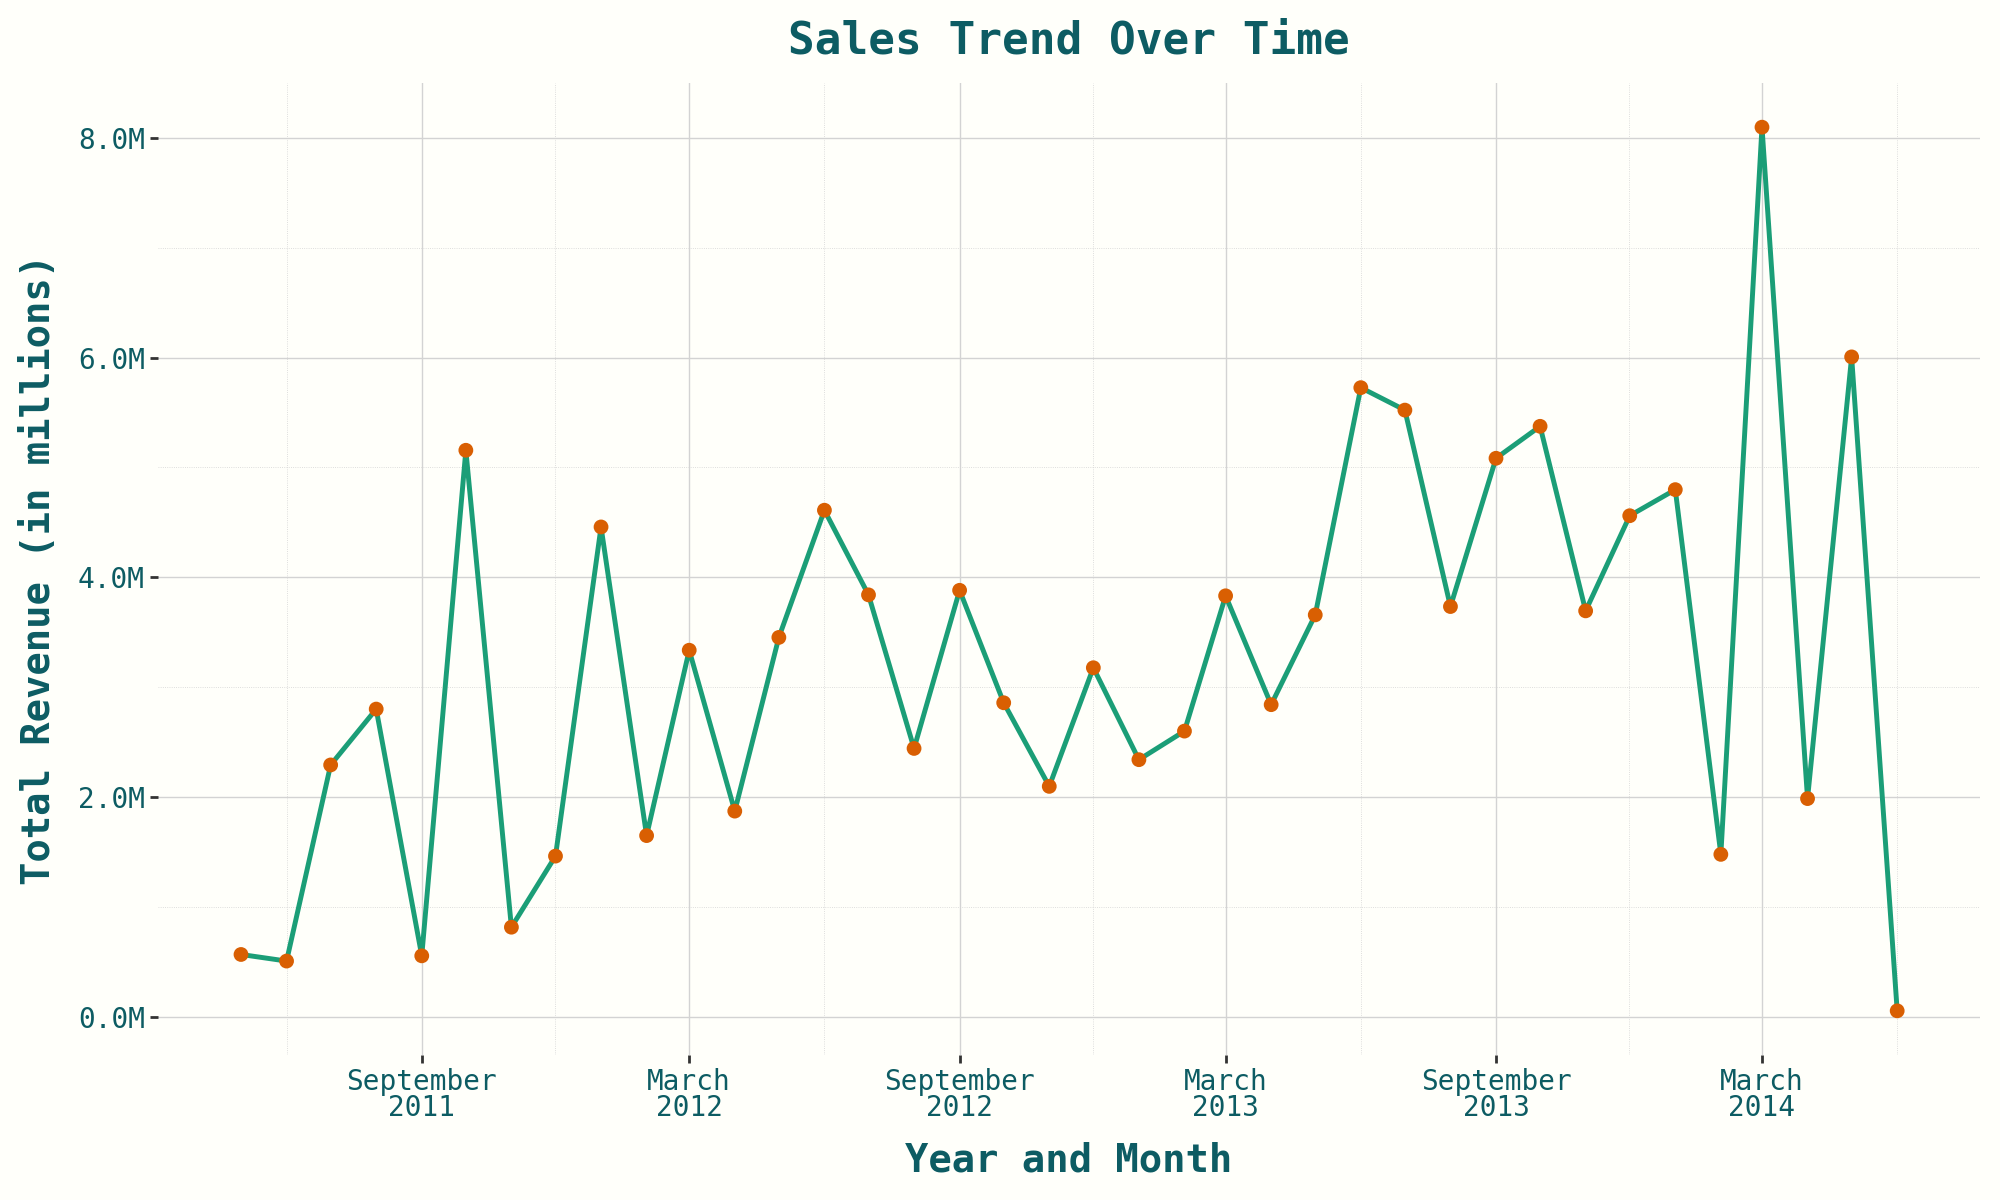

In [742]:
# Create a time-series plot for sales trends
sales_trends_linechart = (
    ggplot(sales_trends_df, aes(x='Date', y='TotalRevenue'))
    + geom_line(color='#1B9E77', size=1)
    + geom_point(color='#D95F02', size=2) 
    + labs(
        title='Sales Trend Over Time',
        x='Year and Month',
        y='Total Revenue (in millions)'
    )
    # Format the y-axis to millions
    + scale_y_continuous(
        labels=lambda x: [f'{i / 1_000_000:.1f}M' for i in x]
    ) 
    + scale_x_datetime(
        breaks=date_breaks(width="6 months"), 
        date_labels="%B\n%Y", 
    )
    + bengtegard_theme()
)

sales_trends_linechart

Analyzing the company's revenue trends over time reveals several important observations:

**Key Insights:**

* **Overall Positive Trend:** The company has experienced a general upward trajectory in total revenue, indicating growth and expansion.

* **Monthly Fluctuations:** Despite the overall positive trend, there are significant month-to-month variations in revenue, suggesting potential volatility or seasonal influences.

* **Consistent Growth (June 2011 to January 2014):** From June 2011, with a total revenue of $567,021, to January 2014, reaching $1,985,886, the company demonstrated steady growth, reflecting successful strategies and market acceptance.

* **February 2014 Decline:** In February 2014, a sharp decline in revenue to $1,478,213 occurred, a decrease of $3,319,815. Such a significant drop could be attributed to factors like seasonality, market disruptions, or operational challenges.

* **March 2014 Surge:** The following month, March 2014, saw the highest recorded revenue since the company's inception, reaching $8,097,036. This substantial increase may be due to successful marketing campaigns, new product launches, or favorable market conditions.

### **Q2: Has the total order amount increased over time?**

In [ ]:
orders_monthly_sql = '''
SELECT 
    YEAR(OrderDate) AS Year,
    MONTH(OrderDate) AS Month,
    COUNT(DISTINCT SalesOrderID) AS TotalOrders
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY Year DESC, Month DESC;
'''

orders_df = pd.read_sql(orders_monthly_sql, con=connection)
# Combine Year and Month into a datetime column
orders_df['Date'] = pd.to_datetime(orders_df[['Year', 'Month']].assign(DAY=1))

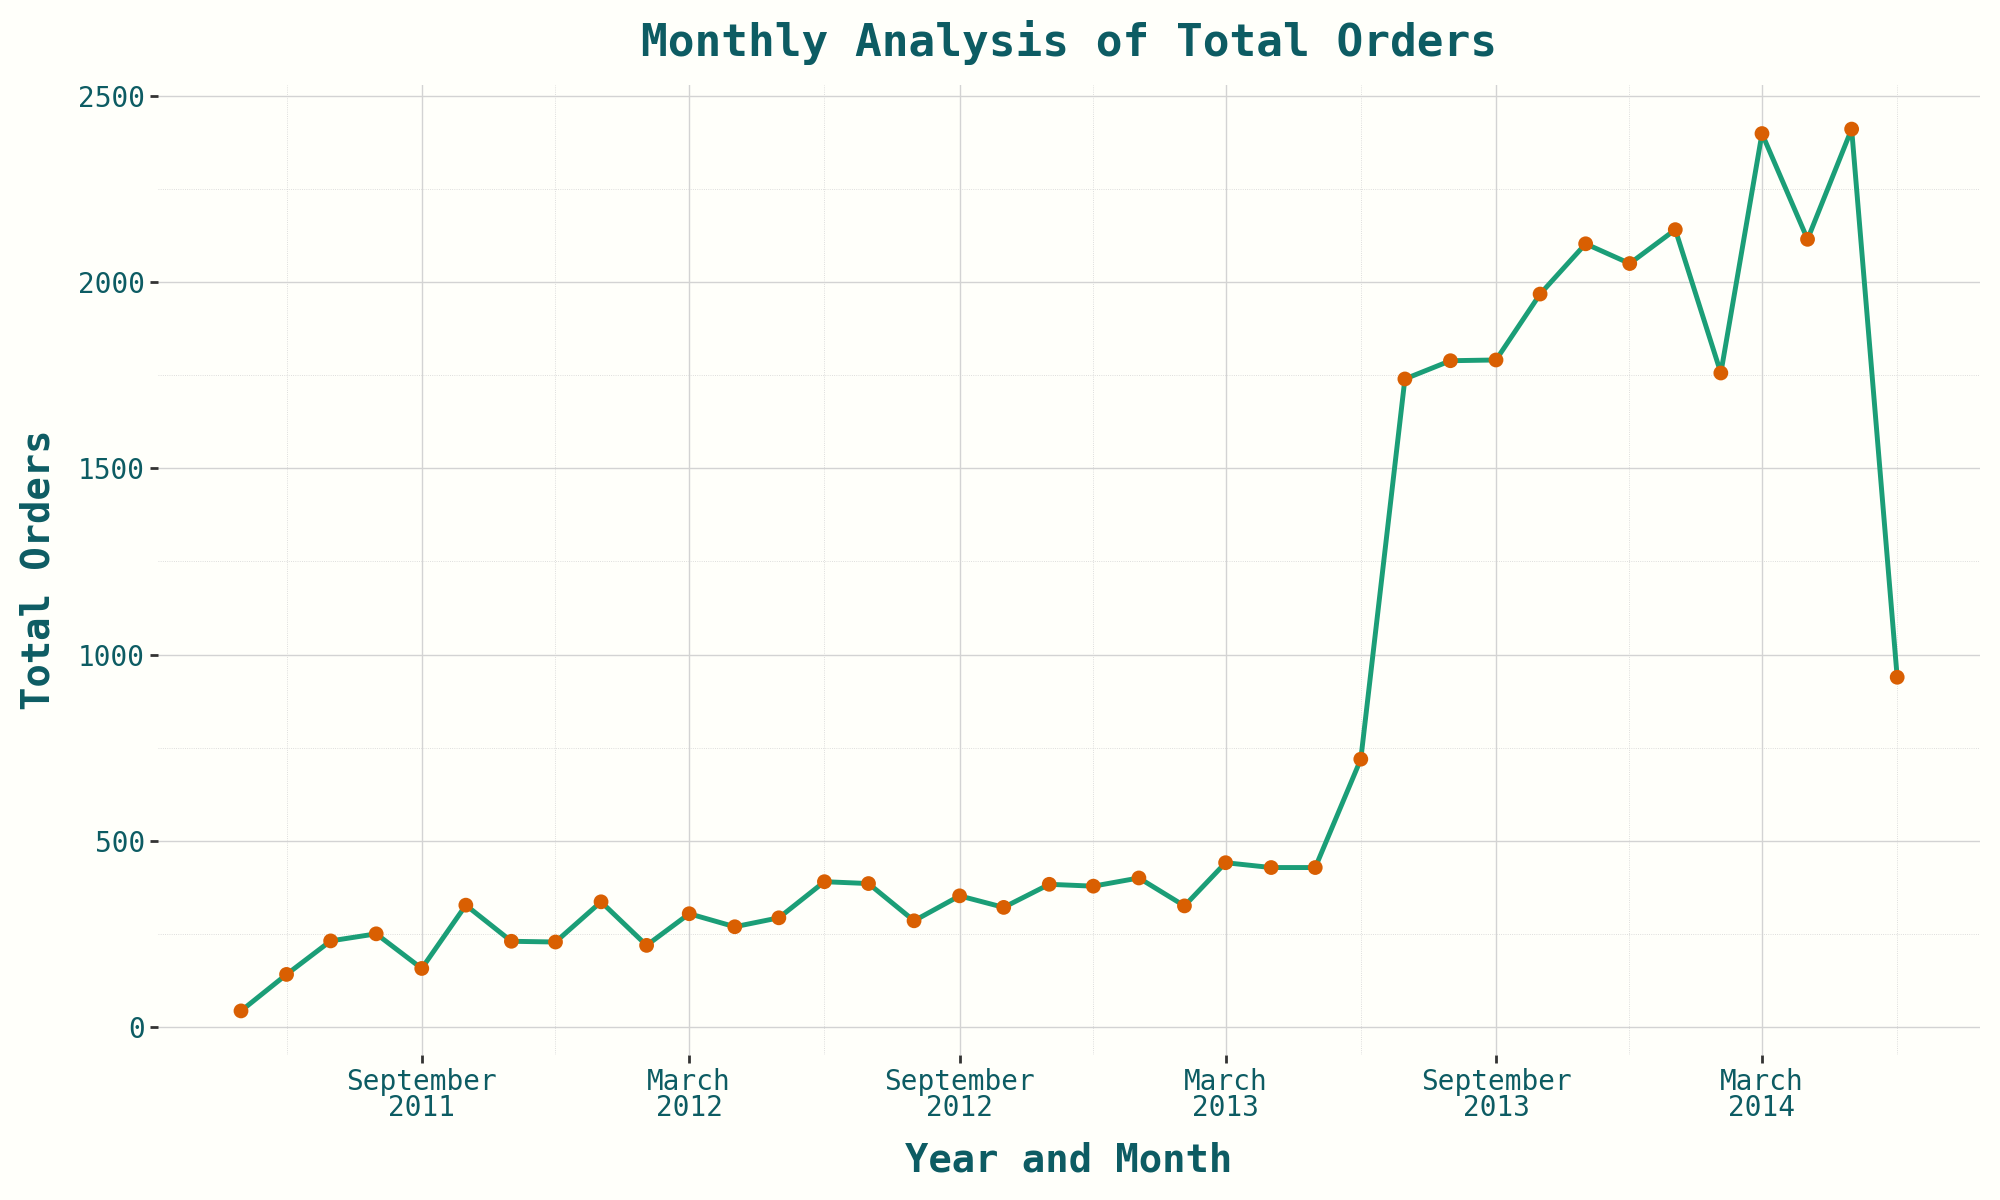

In [744]:
# Create a time-series plot for monthly order amount
monthly_orders_linechart = (
    ggplot(orders_df, aes(x='Date', y='TotalOrders'))
    + geom_line(color='#1B9E77', size=1)
    + geom_point(color='#D95F02', size=2)
    + labs(
        title='Monthly Analysis of Total Orders',
        x='Year and Month',
        y='Total Orders'
    )
    + scale_x_datetime(
        breaks=date_breaks(width="6 months"), 
        date_labels="%B\n%Y", 
    )
    + bengtegard_theme()
)

monthly_orders_linechart

Analyzing the company's order volume over time provides valuable insights into its growth trajectory and market dynamics.

**Key Insights**

**Stable Growth Period (May 2011 - May 2013):**
* May 2011: 43 orders
* May 2013: 428 orders
* Observation: *A consistent increase in order volume, indicating steady market penetration and customer acquisition.*

**Rapid Expansion Phase (Post-May 2013):**
* June 2013: Orders surged from 719 to 1,740 within a month.
* Peak: May 2014 reached 2,400 orders, marking the highest volume since the company's inception.
* Observation: *This sharp increase suggests successful marketing campaigns, product launches, or entry into new markets.*

**Decline Period (Post-May 2014):**
* Final Recorded Data: Orders decreased to 939.
* Observation: *A significant drop in order volume, potentially indicating market saturation, increased competition, or internal challenges.*

### **Q3: How does profit margins change monthly?**

In [ ]:
profit_sql = '''
WITH MonthlySummary AS (
    SELECT 
        YEAR(SH.OrderDate) AS Year,
        MONTH(SH.OrderDate) AS Month,
        SUM(SD.LineTotal) AS TotalRevenue,  
        SUM((SD.UnitPrice - P.StandardCost) * SD.OrderQty) AS TotalProfit
    FROM Sales.SalesOrderHeader AS SH
    INNER JOIN Sales.SalesOrderDetail AS SD
        ON SH.SalesOrderID = SD.SalesOrderID
    INNER JOIN Production.Product AS P
        ON SD.ProductID = P.ProductID
    GROUP BY YEAR(SH.OrderDate), MONTH(SH.OrderDate)
)
SELECT 
    Year,
    Month,
    TotalRevenue,
    TotalProfit,
    CASE 
        WHEN TotalRevenue = 0 THEN 0  -- Avoid division by zero
        ELSE (TotalProfit / TotalRevenue) * 100
    END AS ProfitMargin
FROM MonthlySummary
ORDER BY Year DESC, Month DESC;
'''

profit_df = pd.read_sql(profit_sql, con=connection)
# Combine Year and Month to a datetime column
profit_df['Date'] = pd.to_datetime(profit_df[['Year', 'Month']].assign(DAY=1))

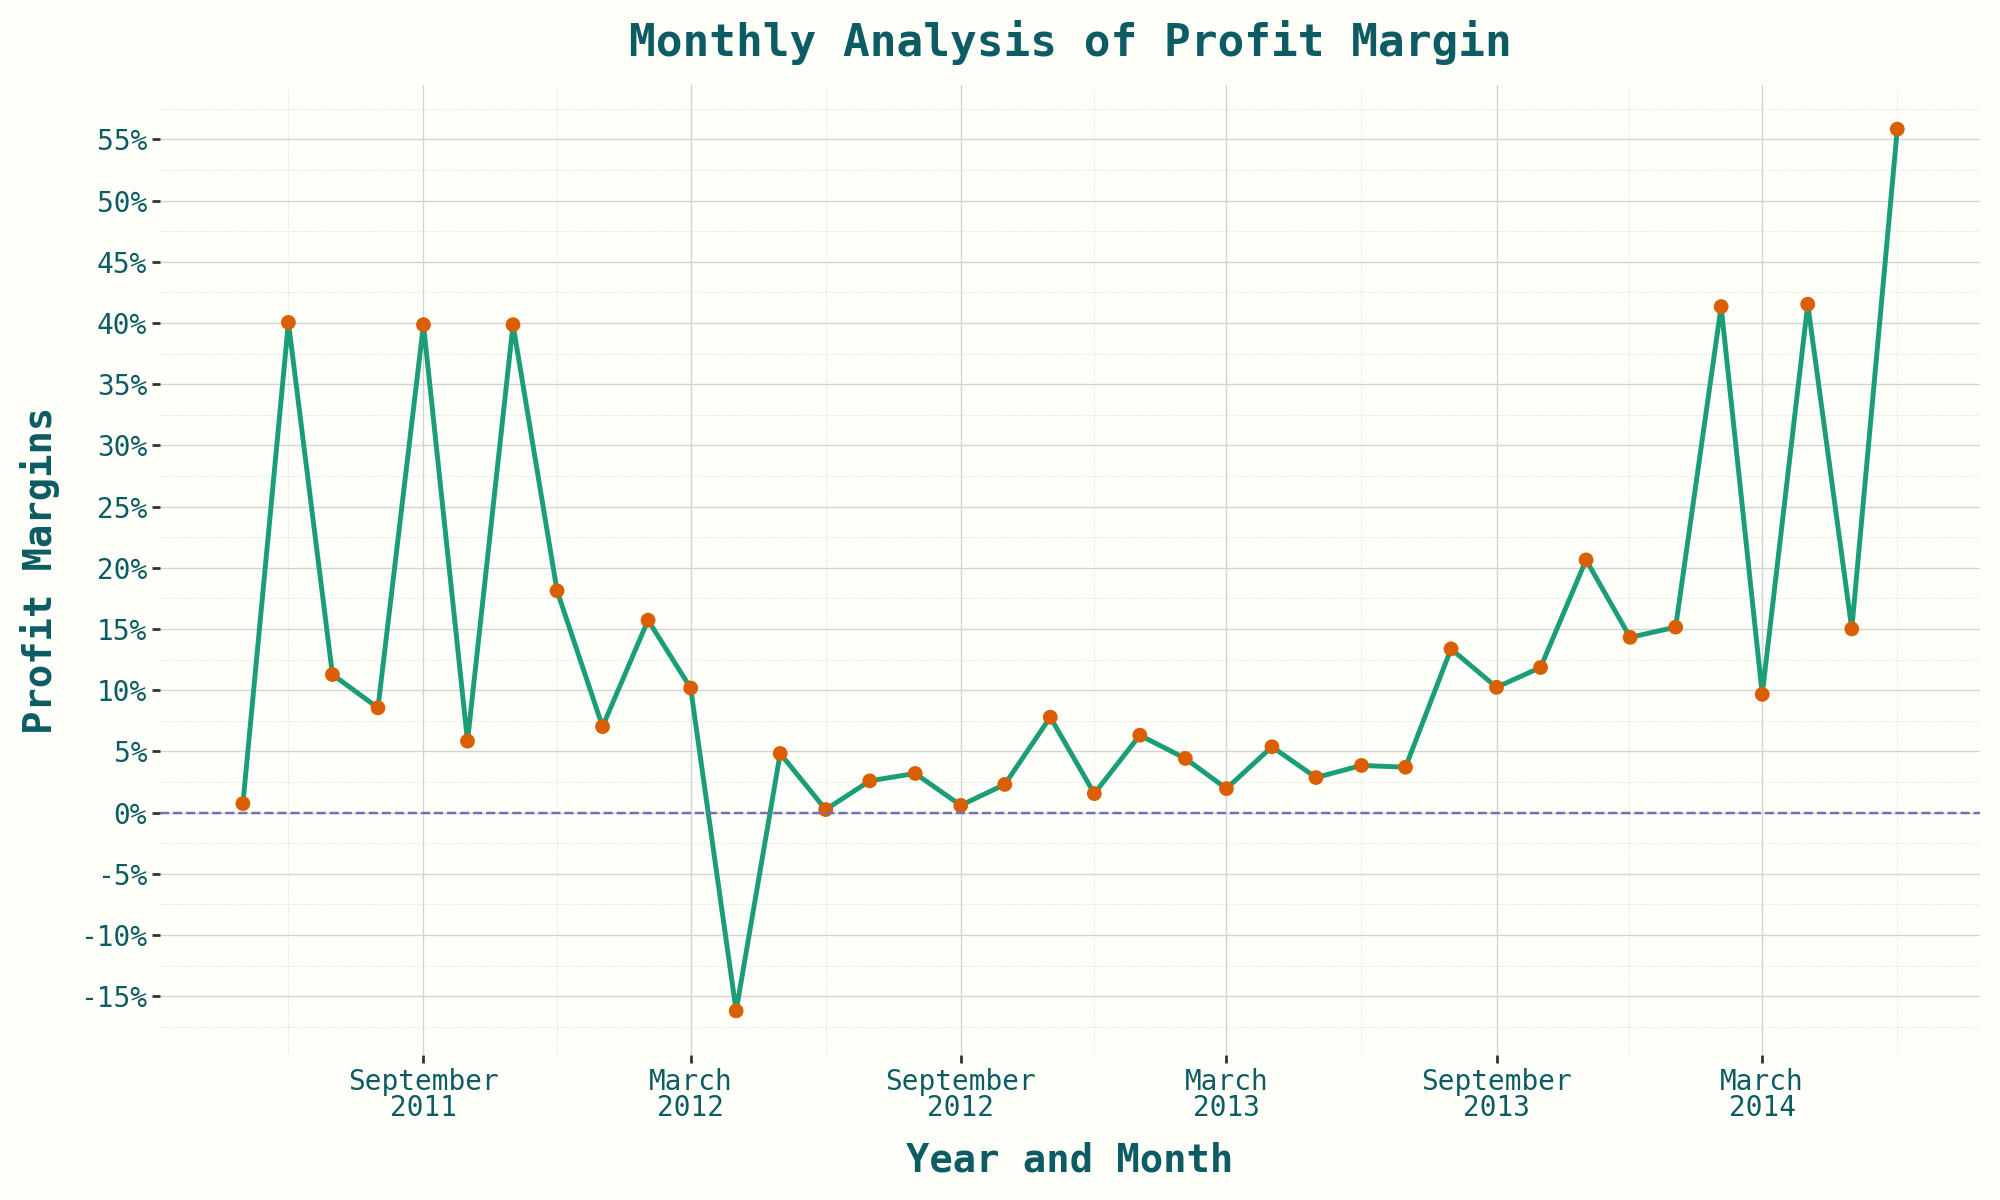

In [746]:
# Create a time-series plot for monthly profit margins
profit_linechart = (
    ggplot(profit_df, aes(x='Date', y='ProfitMargin'))
    + geom_line(color='#1B9E77', size=1)
    + geom_point(color='#D95F02', size=2)
    + geom_hline(yintercept=0, color='#7570B3', linetype='dashed', size=0.5)
    + labs(
        title='Monthly Analysis of Profit Margin',
        x='Year and Month',
        y='Profit Margins'
    )
    + scale_x_datetime(
        breaks=date_breaks(width="6 months"), 
        date_labels="%B\n%Y", 
    )
    + scale_y_continuous(
        breaks=[i for i in range(-100, 101, 5)],  # Custom breaks every 5%
        labels=[f'{i}%' for i in range(-100, 101, 5)]
    )
    + bengtegard_theme()
)

profit_linechart

Analyzing the company's profit margins over the initial years reveals significant fluctuations, providing insights into its financial health and operational dynamics.

**Profit Margin Trends:**

* **June 2011:** The company achieved a profit margin of 40%, indicating a strong start.

* **April 2012:** A decline to -16% suggests challenges that led to operating losses.

* **Post-April 2012:** A period of steady positive profit margins indicates recovery and stabilization.

* **August 2013:** An increase to 13.3% reflects improved profitability, followed by renewed fluctuations.

**Key insight:**

The overall upward trend in profit margins indicates that the company is on a positive trajectory, with the potential for continued growth.

#### **Q4: Which country has generated the highest revenue and profits?**

In [ ]:
country_profit = '''
SELECT 
    ST.CountryRegionCode AS Country,
    SUM(SD.LineTotal) AS TotalRevenue,
    SUM((SD.UnitPrice - P.StandardCost) * SD.OrderQty) AS TotalProfit,
    CASE    
        WHEN SUM(SD.LineTotal) = 0 THEN 0 -- Avoid divison by zero
        ELSE (SUM((SD.UnitPrice - P.StandardCost) * SD.OrderQty) / SUM(SD.LineTotal)) * 100
    END AS ProfitMargin
FROM Sales.SalesTerritory AS ST
INNER JOIN Sales.SalesOrderHeader AS SH
    ON ST.TerritoryID = SH.TerritoryID
INNER JOIN Sales.SalesOrderDetail AS SD
    ON SH.SalesOrderID = SD.SalesOrderID
INNER JOIN Production.Product AS P
    ON SD.ProductID = P.ProductID
GROUP BY ST.CountryRegionCode
ORDER BY TotalRevenue DESC;
'''

country_df = pd.read_sql(country_profit, con=connection)
# Convert the column ProfitMargin to string
country_df['ProfitMarginText'] = country_df['ProfitMargin'].apply(lambda x: f'{x:.1f}%')

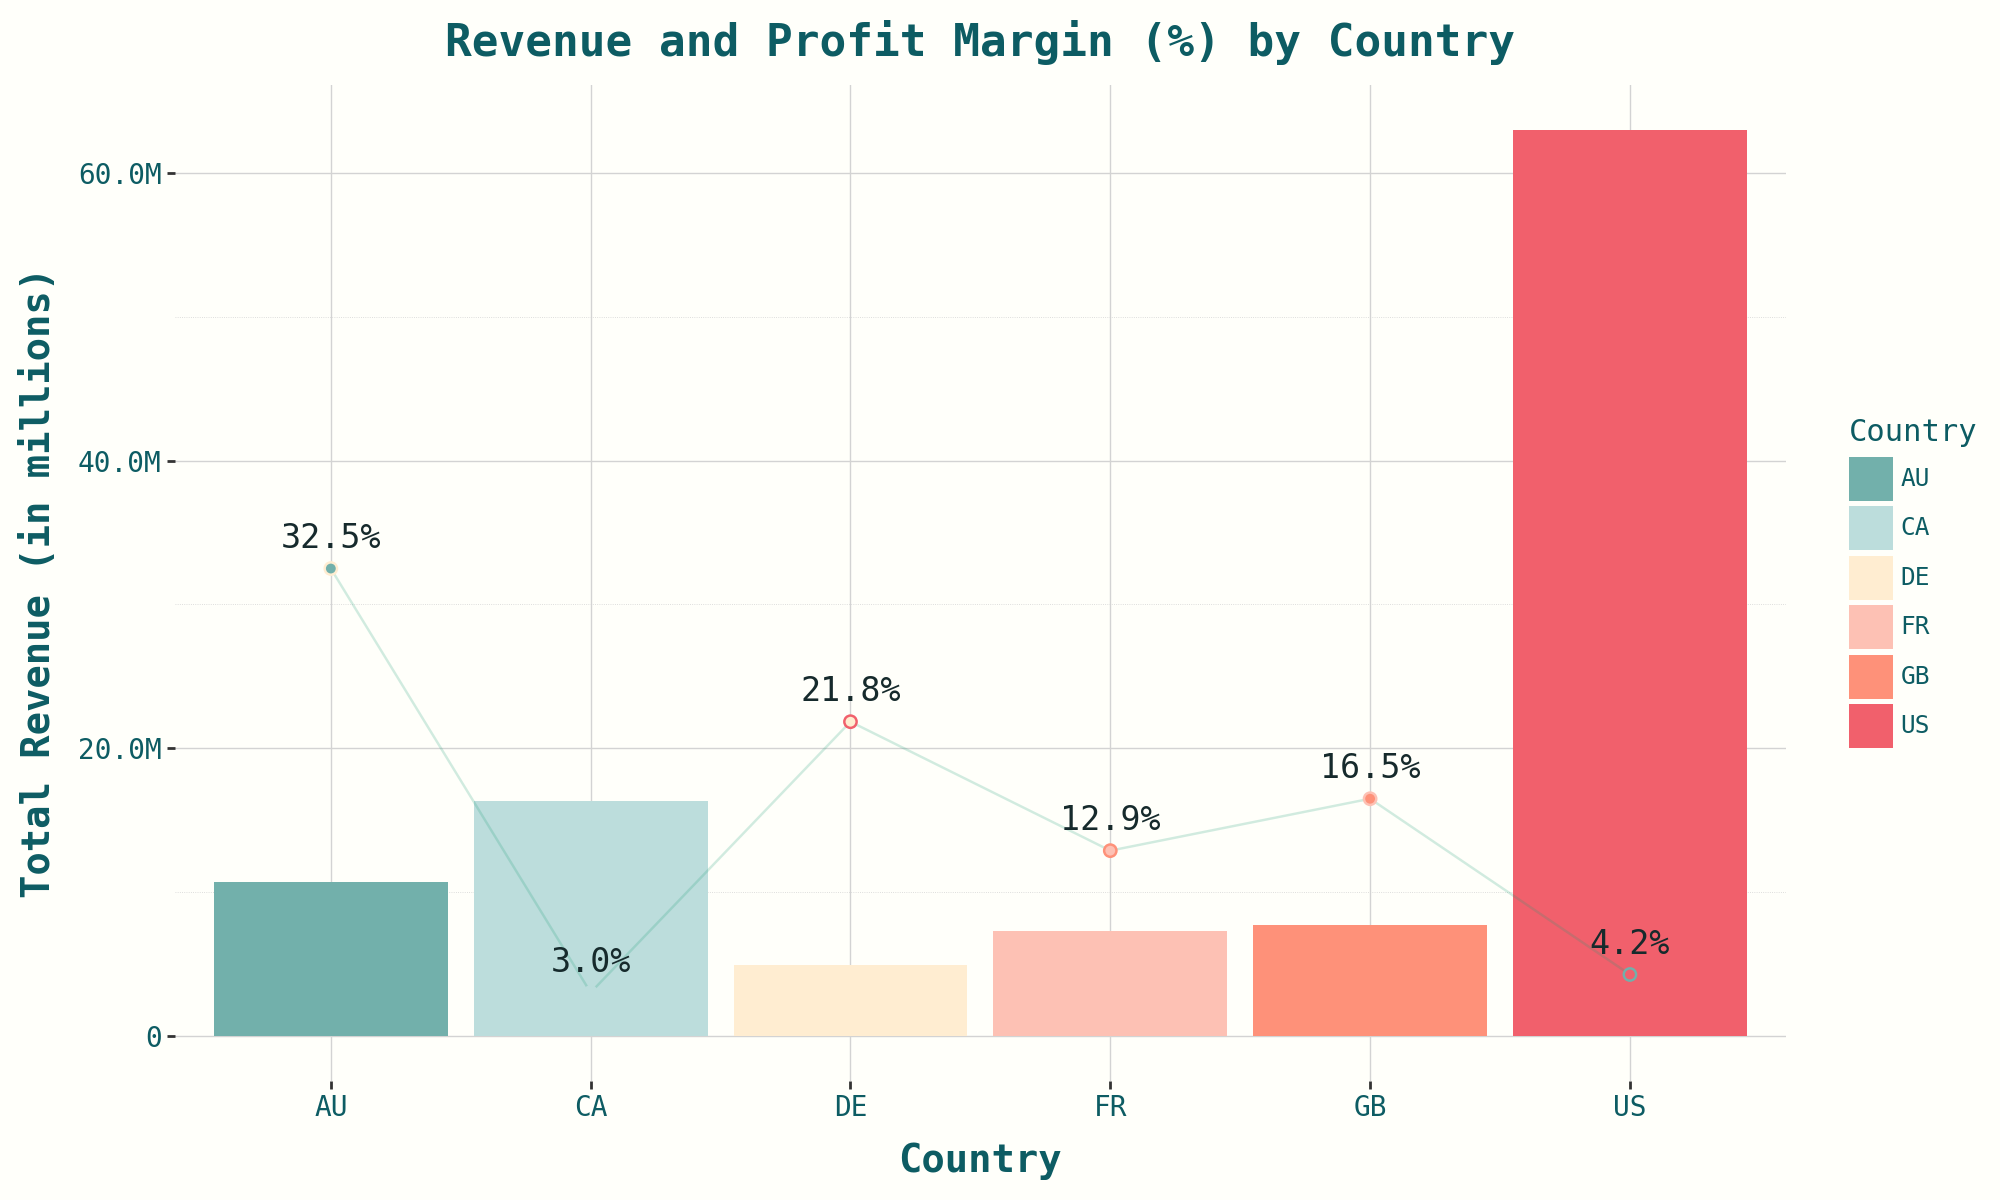

In [748]:
# This plot combines a bar chart and an overlayed line plot to present a clear comparison of Total Revenue and Profit Margin (scaled to match the revenue axis in millions) for each country 
country_plot = (
    ggplot(country_df, aes(x='Country', fill='Country'))
    + geom_bar(aes(y='TotalRevenue'), 
               stat='identity', 
               width=0.9)
    + geom_line(aes(y='ProfitMargin * 1e6'), 
                color='#1B9E77',alpha=0.2, 
                group=1)
    + geom_point(aes(y='ProfitMargin * 1e6'), 
                 color=bar_palette, 
                 size=2)
    + geom_text(
        aes(y='ProfitMargin * 1e6 + 2100000', label='ProfitMarginText'),
        color='#162A2C',
        size=12,
    )
    + labs(
        title='Revenue and Profit Margin (%) by Country',
        x='Country',
        y='Total Revenue (in millions)'
    )
    + scale_y_continuous(
        name='Total Revenue (in millions)',
        labels= lambda x: [f'{i / 1e6:.1f}M' if i > 1e6 else f'{i:.0f}' for i in x]
    ) 
    + scale_fill_manual(values=BAR_PALETTE)
    + bengtegard_theme()
)

country_plot

Analyzing the company's revenue and profit margins across different countries provides valuable insights into market performance and profitability.

**Revenue and Profit Margin by Country:**

**United States:**                   
* Total Revenue: $62,997,591 
* Profit Margin: 4.2%
* Profit: $2,645,897

**Canada:**
* Total Revenue: $16,355,770
* Profit Margin: 3.0%
* Profit: $490,673

**Australia:**
* Total Revenue: $10,655,336
* Profit Margin: 32.5%
* Profit: $3,461,485

**Great Britain:**
* Total Revenue: $7,670,721
* Profit Margin: 16.5%
* Profit: $1,265,668
  
**France:**
* Total Revenue: $7,251,556
* Profit Margin: 12.9%
* Profit: $935,448

**Germany:**
* Total Revenue: $4,915,408
* Profit Margin: 21.8%
* Profit: $1,071,552

**Key Insights:**

Revenue Leaders: *The United States and Canada are the top revenue-generating countries, contributing significantly to the company's overall income.*

**Profitability Analysis:**
* High Profit Margins: *Australia (32.5%), Germany (21.8%), and Great Britain (16.5%) exhibit substantial profit margins, indicating efficient operations and favorable market conditions in these regions.*

* Lower Profit Margins: *Despite high revenues, the United States (4.2%) and Canada (3.0%) have relatively lower profit margins, suggesting higher operational costs or competitive pressures.*

#### **Q5: How does each Sales territory contribute to profit margins over time?**

In [ ]:
territory_profit_sql = '''
WITH MonthlyProfitTerritory AS (
    SELECT
        T.[Group]AS Territory,
        YEAR(SH.OrderDate) AS Year,
        MONTH(SH.OrderDate) AS Month,
        SUM(SD.LineTotal) AS TotalRevenue,  
        SUM((SD.UnitPrice - P.StandardCost) * SD.OrderQty) AS TotalProfit
    FROM Sales.SalesOrderHeader AS SH
    INNER JOIN Sales.SalesOrderDetail AS SD
        ON SH.SalesOrderID = SD.SalesOrderID
    INNER JOIN Production.Product AS P
        ON SD.ProductID = P.ProductID
    INNER JOIN Sales.SalesTerritory AS T
        ON SH.TerritoryID = T.TerritoryID
    GROUP BY T.[Group], YEAR(SH.OrderDate), MONTH(SH.OrderDate)
)
SELECT
    Territory,
    Year,
    Month,
    TotalRevenue,
    TotalProfit,
    CASE 
        WHEN TotalRevenue = 0 THEN 0  -- Avoid division by zero
        ELSE (TotalProfit / TotalRevenue) * 100
    END AS ProfitMargin
FROM MonthlyProfitTerritory
ORDER BY Territory, Year, Month;
'''

territory_profit_df = pd.read_sql(territory_profit_sql, con=connection)
# Combine Year and Month to a datetime column
territory_profit_df['Date'] = pd.to_datetime(territory_profit_df[['Year', 'Month']].assign(DAY=1))

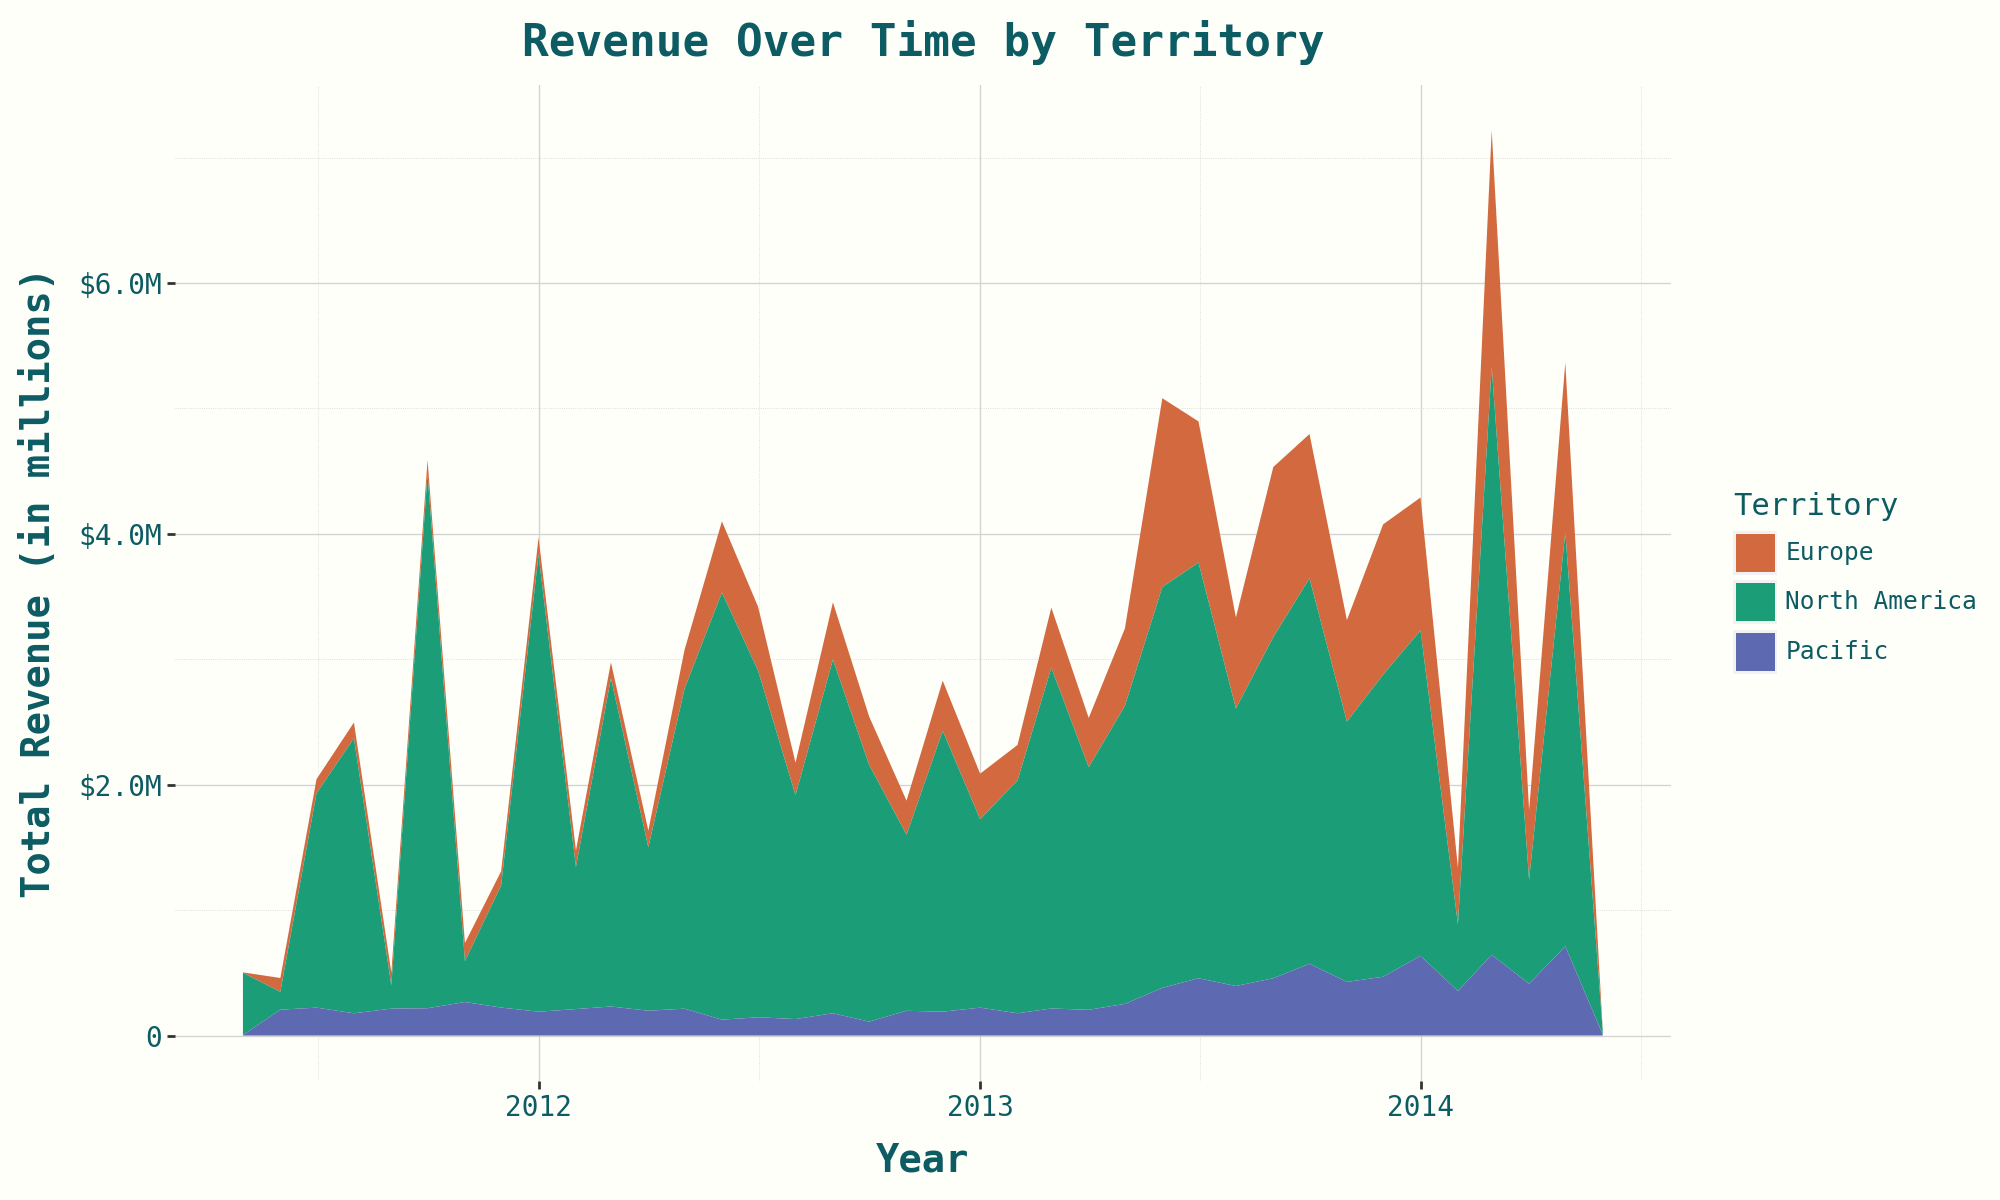

In [750]:
# Create an area chart to visualize Revenue by Territory over time
territory_revenue_areachart = (
    ggplot(territory_profit_df, aes(x='Date', y='TotalRevenue', fill='Territory', group='Territory'))
    + geom_area(size=1.2)
    + labs(
        title='Revenue Over Time by Territory',
        x='Year',
    )
    + scale_y_continuous(
        name='Total Revenue (in millions)',
        labels=lambda x: [f'${i / 1e6:.1f}M' if i > 1e6 else f'{i:.0f}' for i in x]
    )
    + scale_x_datetime(
        breaks=date_breaks(width='1 year'), 
        date_labels="%Y",
    )
    + scale_fill_manual(values=BAR_COLOR)
    + bengtegard_theme()
)

territory_revenue_areachart

**Key Insights:**

* **Europe:** Europe has consistently led in total revenue over time, indicating a strong and sustained market presence.

* **North America:** Initially, North America closely matched Europe's revenue figures. However, around mid-2012, North America's revenue growth began to lag behind Europe's, resulting in a gradual decline in its revenue share.

* **Pacific:** The Pacific region has the lowest total revenue compared to Europe and North America. Despite this, it has demonstrated steady growth over time, suggesting potential for future expansion.

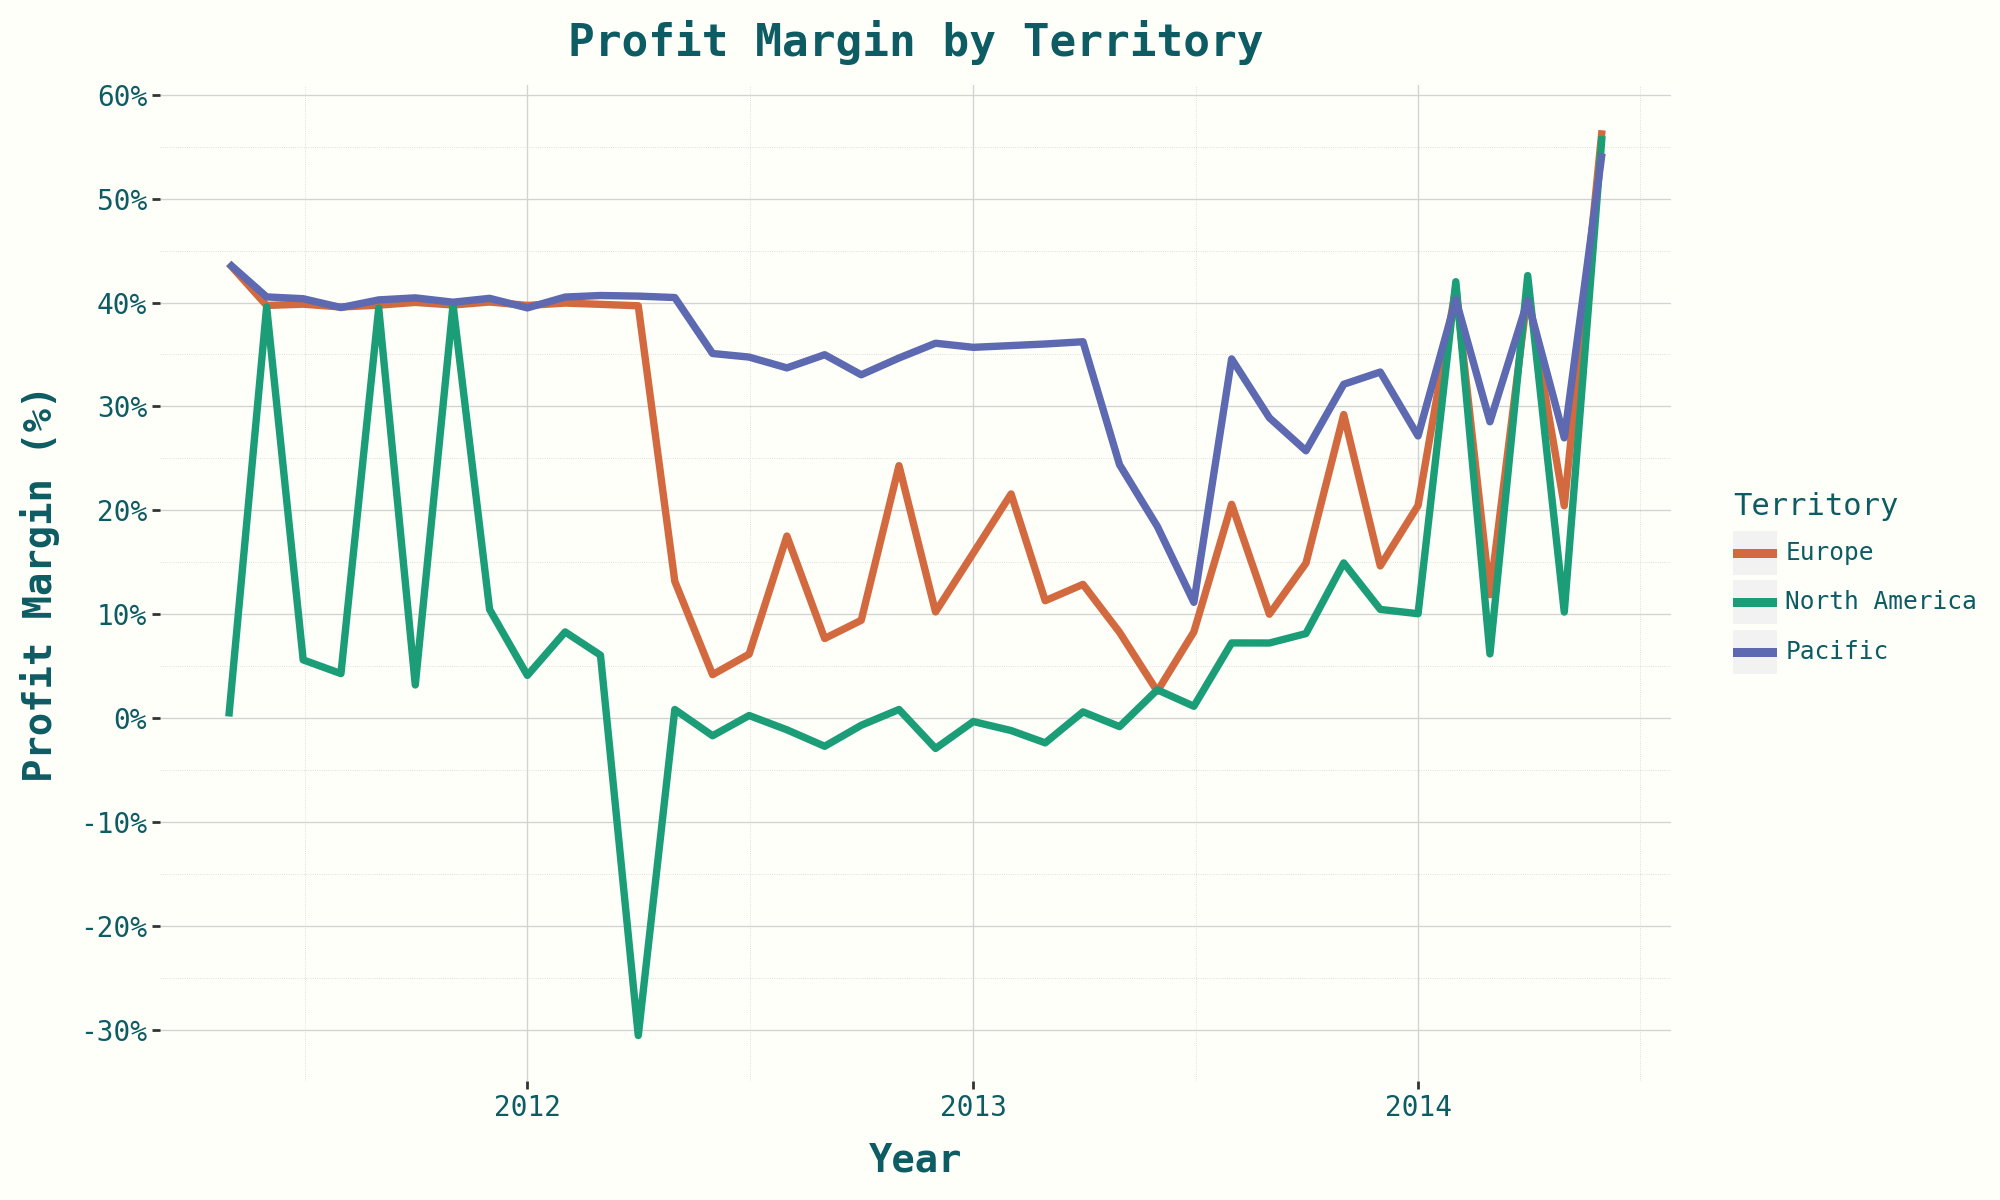

In [751]:
# Create an area chart to visualize Revenue by Territory over time
territory_profit_linechart = (
    ggplot(territory_profit_df, aes(x='Date', y='ProfitMargin', group='Territory', color='Territory'))
    + geom_line(size=1.5)
    + labs(
        title='Profit Margin by Territory',
        x='Year',
        y='Profit Margin (%)'
    )
    + scale_y_continuous(
        breaks=[i for i in range(-100, 101, 10)],  # Custom breaks every 10%
        labels=[f'{i}%' for i in range(-100, 101, 10)]
    )
    + scale_x_datetime(
        breaks=date_breaks(width='1 year'), 
        date_labels="%Y"
    )
    + scale_color_manual(values=BAR_COLOR)
    + bengtegard_theme()
)

territory_profit_linechart

Analyzing the company's financial performance across different regions reveals that, while Europe has generated the highest total revenue over time, the Pacific region boasts the most robust profit margins. In contrast, North America, despite its substantial revenue, exhibits the lowest profit margins.

**Key Insights:**

* Europe: *Leading in total revenue, Europe's high sales volume indicates effective sales strategies. This region achieves good profit margins over time, even 2012 provides clear struggles, Europes slowly recovers with an favorable profit margins in 2014.*

* North America: *Despite significant revenue figures, North America's lower profit margins point to potential challenges such as higher operational costs, competitive pricing pressures, or other factors diminishing profitability.*
  
* Pacific: *This region achieves superior profit margins, suggesting exceptional cost management, or favorable market conditions that enhance profitability relative to revenue.*

### **Q6: Top 10 products with the highest profit?**

In [ ]:
product_profit_sql = '''
WITH ProductProfit AS (
    SELECT 
        P.ProductID,
        P.Name AS ProductName,
        SUM(SD.LineTotal) AS TotalRevenue,
        SUM((SD.UnitPrice - P.StandardCost) * SD.OrderQty) AS TotalProfit,
        CASE 
            WHEN SUM(SD.LineTotal) = 0 THEN 0  -- Avoid division by zero
            ELSE (SUM((SD.UnitPrice - P.StandardCost) * SD.OrderQty) / SUM(SD.LineTotal)) * 100
        END AS ProfitMargin
    FROM Production.Product AS P
    INNER JOIN Sales.SalesOrderDetail AS SD
        ON SD.ProductID = P.ProductID
    GROUP BY P.ProductID, P.Name
)
SELECT TOP 10
    ProductName,
    TotalRevenue,
    TotalProfit,
    ProfitMargin
FROM ProductProfit
ORDER BY TotalProfit DESC;
'''

product_profit_df = pd.read_sql(product_profit_sql, con=connection)
product_profit_round_df = product_profit_df.round()
# Ensure ProductName is a categorical variable ordered by the current order in the dataframe
product_profit_round_df['ProductName'] = product_profit_round_df['ProductName'].astype('category').cat.reorder_categories(product_profit_round_df['ProductName'], ordered=True)
# creates a list to reorder the x-axis
product_profit_list = product_profit_df['ProductName'].tolist()[::-1]

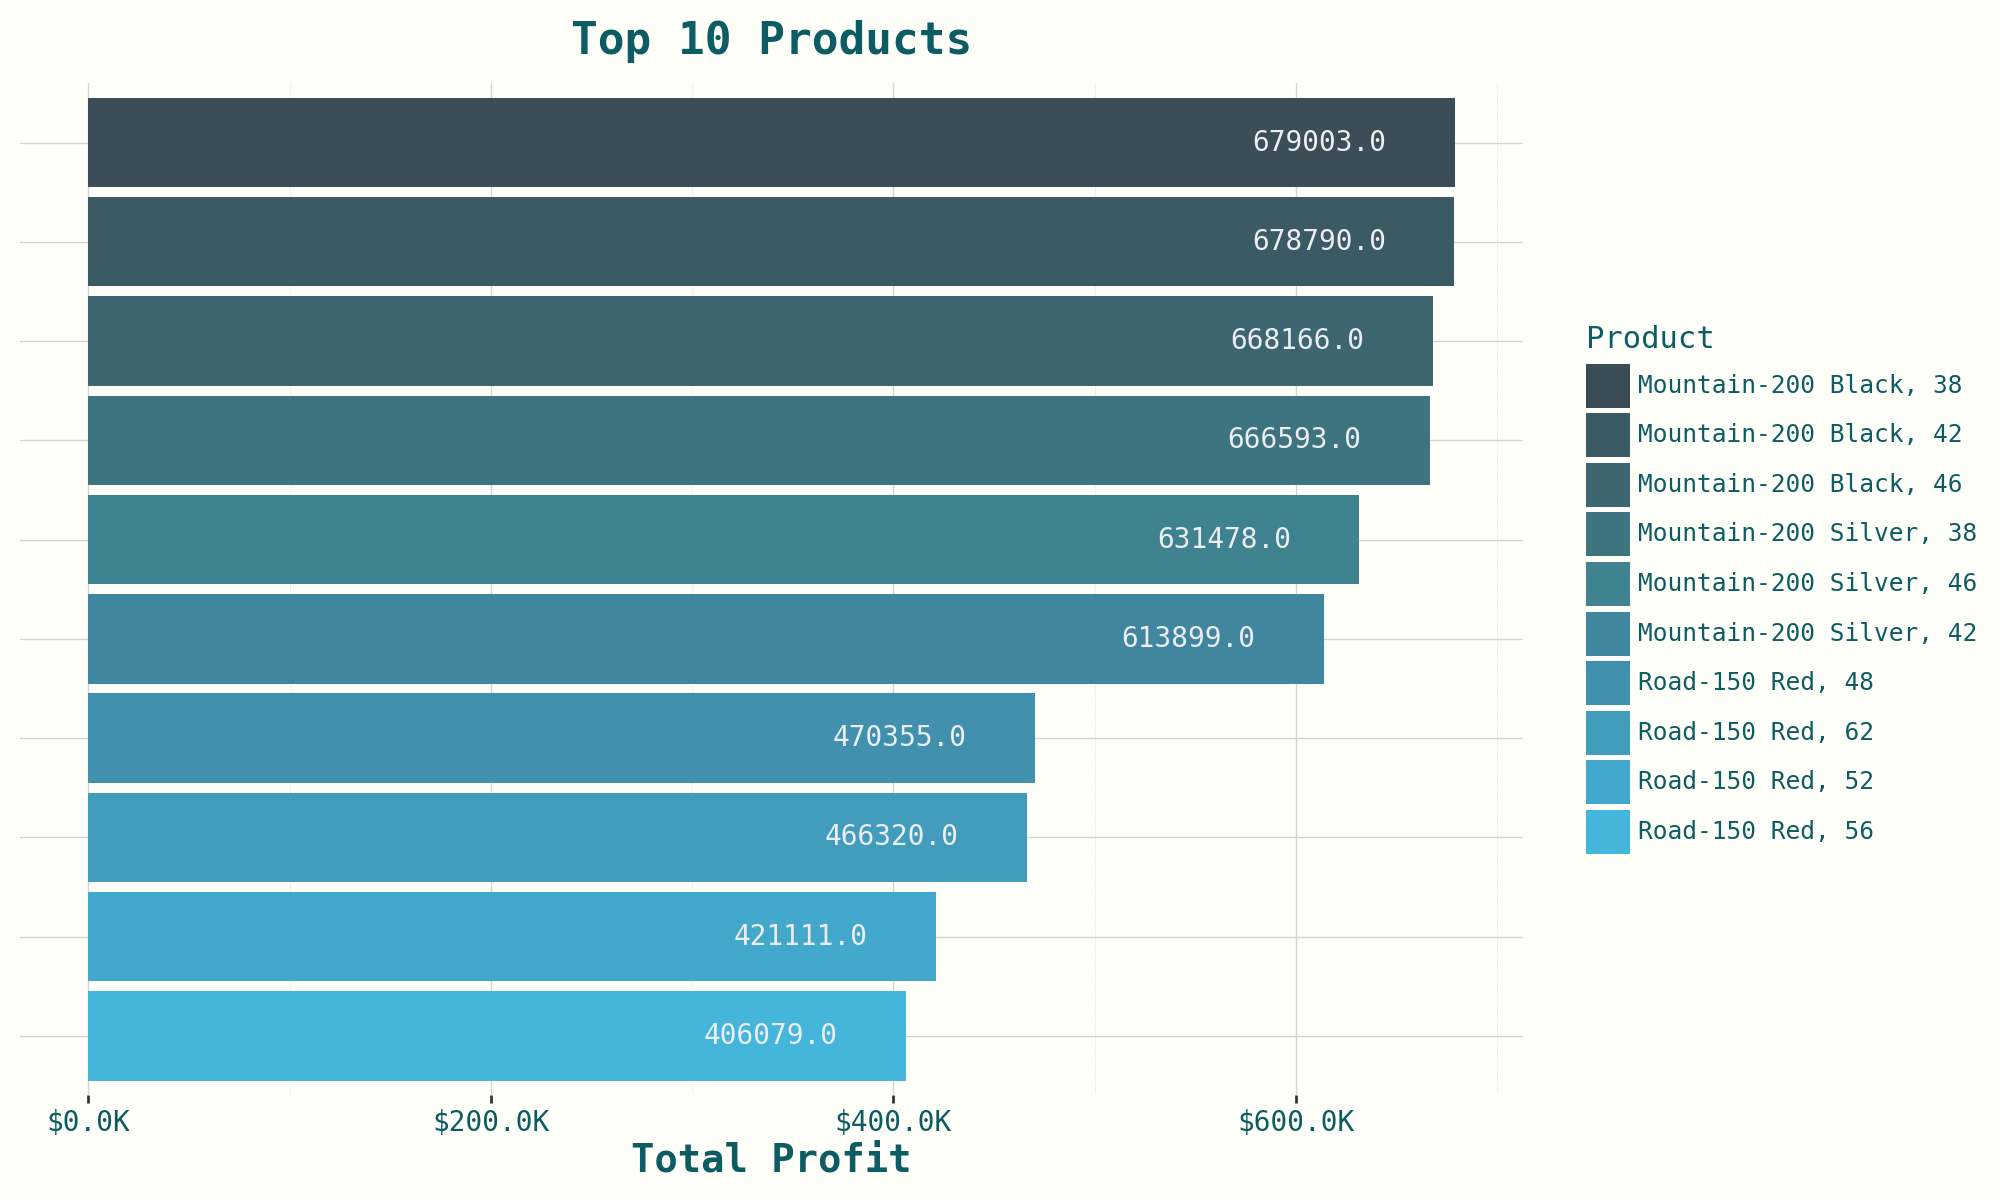

In [753]:
# Create an horizonal bar plot to show top 10 most profitable products
top_products_barplot = (
    ggplot(product_profit_round_df, aes(y='TotalProfit', x='ProductName', fill='ProductName'))
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(
        title='Top 10 Products',
        y='Total Profit',
        fill='Product'
    )
    + geom_text(
        aes(label="TotalProfit"),
        nudge_y=-0.05 * product_profit_round_df["TotalProfit"].max(),
        size=10,
        color="#EDEEF3",
        ha="right"
    ) +
   scale_y_continuous(
       labels=lambda y: [f'${i / 1e3:.1f}K' for i in y] 
    ) 
    + scale_fill_manual(values=GRADIENT_COLORS)
    + scale_x_discrete(limits=product_profit_list)
    + bengtegard_theme(
        axis_text_y=element_blank(),
        axis_title_y = element_blank(),
        axis_ticks_major_y=element_blank(),
        axis_title_x=element_text(margin={'t': 14})
    )
)

top_products_barplot

**Key Insights:**

The Mountain-200 Black/Silver series stands out as the company's most profitable product line, with the Mountain-200 Black, 38 variant leading the pack. This variant has generated a total profit of $679,003, underscoring its significant contribution to the company's bottom line.

In contrast, the Road-150 Red, 48 variant has a total profit of $470,355, which is approximately $208,648 less than the Mountain-200 Black, 38. This substantial difference highlights the considerable profit disparity between the top-performing Mountain-200 Black variants and the Road-150 Red variants.

These insights suggest that focusing on promoting and expanding the Mountain-200 Black/Silver series could be a strategic move for the sales team to maximize profitability.

#### **Q7: Which product categories have the highest averages sales? And what is the average cost for each category?**

In [ ]:
category_profit_sql = '''
WITH CategorySales AS (
    SELECT
        PC.Name AS ProductCategory,
        AVG(SD.LineTotal) AS AverageSales,
        AVG(P.StandardCost) AS AverageCost
    FROM Sales.SalesOrderDetail AS SD
    INNER JOIN Production.Product AS P
        ON SD.ProductID = P.ProductID
    INNER JOIN Production.ProductSubcategory AS PSC
        ON P.ProductSubcategoryID = PSC.ProductSubcategoryID
    INNER JOIN Production.ProductCategory AS PC
        ON PSC.ProductCategoryID = PC.ProductCategoryID
    GROUP BY
        PC.Name
)
SELECT
    ProductCategory,
    AverageSales,
    AverageCost
FROM
    CategorySales
ORDER BY AverageSales DESC;
'''

category_profit_df = pd.read_sql(category_profit_sql, con=connection)
# Reshaping data to long format using melt for grouped bar chart
long_df = pd.melt(category_profit_df, id_vars=['ProductCategory'], value_vars=['AverageSales', 'AverageCost'], var_name='Metric', value_name='Value')

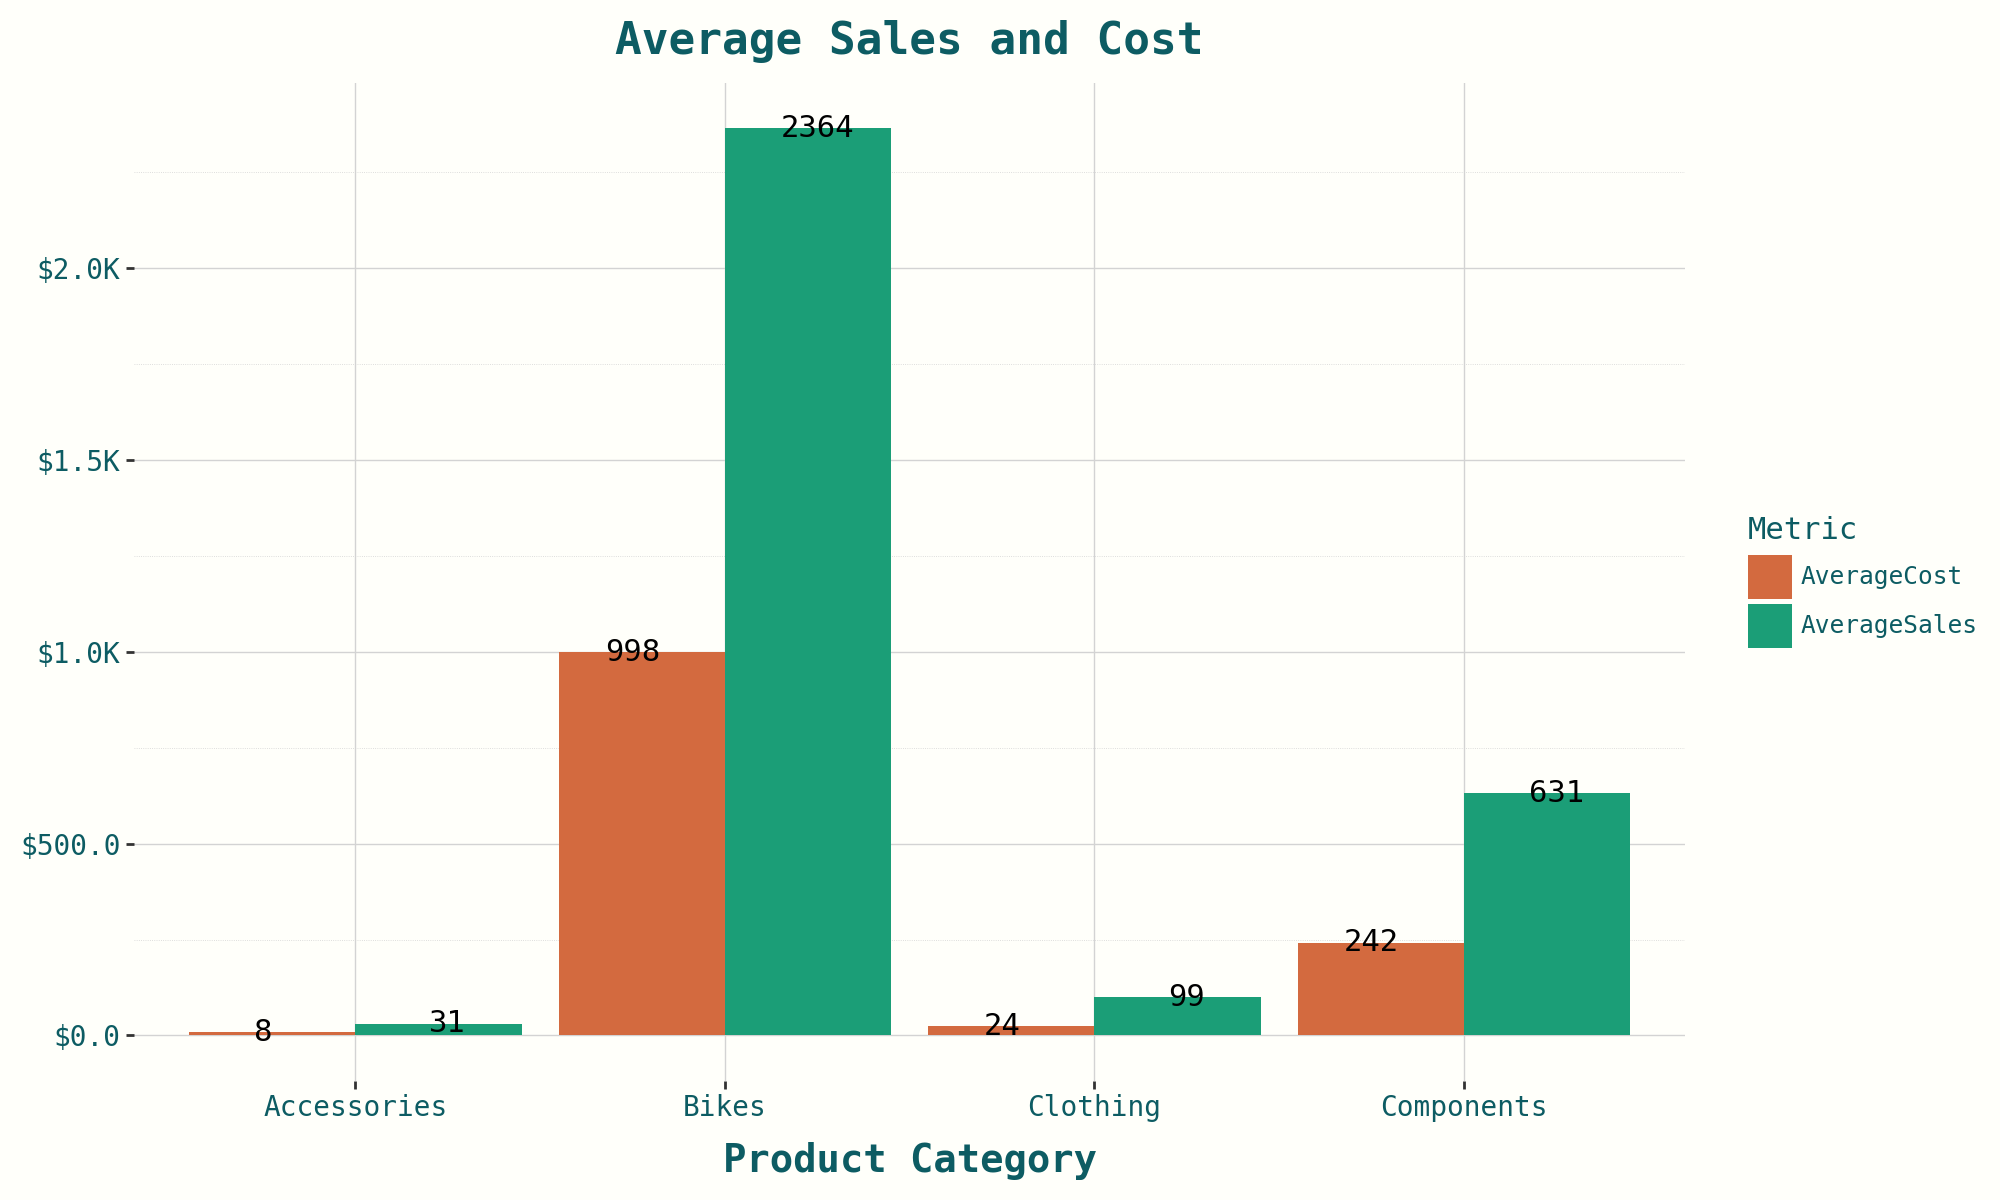

In [755]:
# A grouped bar chart for averages sales and cost for each product category
product_category_barplot = (
    ggplot(long_df, 
           aes(x='ProductCategory',  
               y='Value', 
               fill='Metric')) 
    + geom_bar(stat='identity', 
               position='dodge')
    +labs(
        title='Average Sales and Cost',
        x='Product Category'
    )
    + geom_text (aes(label='Value'), 
                 position=position_dodge(width=1),
                 format_string='{:.0f}'
                 )
    + scale_fill_manual(values=BAR_COLOR)
    + scale_y_continuous(
        labels=lambda y:[f'${i / 1000:.1f}K' if i >= 1000 else f'${i:.1f}' for i in y]
    )
    + bengtegard_theme(axis_title_y = element_blank())
)

product_category_barplot

Analyzing the average sales to average cost ratios across various product categories provides valuable insights into their profitability and cost efficiency.

Cost Ratio: Average Sales / Average Cost

This ratio indicates the revenue generated for every dollar spent on costs.

1. **Bikes:**
   * Average Sales: $2.364
   * Average Cost: $998
   * Cost Ratio: 2364/998 = 2.4
   * Interpretation: *For every dollar of cost, the company earns approximately $2.40 in sales.*
2. **Components:**
   * Average Sales: $631
   * Average Cost: $242
   * Cost Ratio: 31/242 = 2.6
   * Interpretation: *For every dollar of cost, the company earns approximately $2.60 in sales.*
3. **Clothing:**
   * Average Sales: $99
   * Average Cost: $24
   * Cost Ratio: 99/24 = 4.1
   * Interpretation: *For every dollar of cost, the company earns approximately $4.10 in sales.*
4. **Accessories:**
   * Average Sales: $31
   * Average Cost: $8
   * Cost Ratio: 31/8 = 3.9
   * Interpretation: *For every dollar of cost, the company earns approximately $3.90 in sales.*

**Key Insights:**

* **Clothing:** Exhibits the highest cost ratio, indicating superior cost efficiency. Despite lower average sales, it generates the most revenue per dollar of cost.

* **Bikes:** While having the highest average sales, do not lead in cost efficiency, as reflected by a lower cost ratio compared to Clothing and Accessories.

* **Accessories:** Also demonstrate strong cost efficiency, with a cost ratio close to that of Clothing.

* **Components:** Have a moderate cost ratio, suggesting balanced performance between sales and costs.

### **PHASE 4: Inferential statistics for improving sales in AdventureWorks2022**
**Fictive scenario:**

*Marketing managers at AdventureWorks wants to identify if their increased focus on marketing campaigns in 2013 made any impact on customer spending compared to 2012. By analysing the spending behaviour of customers over time, the team can pinpoint if their marketing stategies is succesfull and tailor future marketing efforts accordingly.* 

**Population:** Active customers in 2012 and 2013.

For hypothesis testing to yield valid conclusions, the sample should be homogeneous regarding the variable of interest — in this case, customer activity. Therefore, when extracting the data, only customers active in both years have been included to ensure that the sample accurately reflects the population of interest.

* **Null Hypothesis (H0):** *the median difference in spending between 2012 and 2013 is zero (no significant change in spending)*
  
* **Alternative Hypothesis (H1):** *The median difference in spending between 2012 and 2013 is not zero (a significant increase or decrease in spending)*

#### 1. Extract relevant sales data in order to test our hypothesis

In [ ]:
# extract historical sales data
customer_spending_sql = '''
-- Query to retrive customer spending data for 2012 and 2013
SELECT C.CustomerID, 
       SUM(CASE WHEN YEAR(S.OrderDate) = 2012 THEN S.TotalDue ELSE 0 END) AS TotalSpending2012,
       SUM(CASE WHEN YEAR(S.OrderDate) = 2013 THEN S.TotalDue ELSE 0 END) AS TotalSpending2013,
       -- Calculates number of days between first and last order
       DATEDIFF(DAY, MIN(S.OrderDate), MAX(S.OrderDate)) / 365.25 AS YearsActive 
FROM Sales.Customer AS C
INNER JOIN Sales.SalesOrderHeader AS S
    ON C.CustomerID = S.CustomerID
WHERE YEAR(S.OrderDate) IN (2012, 2013)
GROUP BY C.CustomerID
-- Filters out customers who were not active in both 2012 and 2013
HAVING COUNT(DISTINCT YEAR(S.OrderDate)) = 2;
'''

# Read the population of sales data into a pandas data frame
customer_spending_df = pd.read_sql(customer_spending_sql, con=connection)

#### 2. Check for normality and asses the symmetry of the data

TotalSpending2012 : Statistics=1628.7431389501712, p=0.0
Data does not appear to be Gaussian (We reject H0).

TotalSpending2013 : Statistics=1681.9202713537363, p=0.0
Data does not appear to be Gaussian (We reject H0).

Skewness: 4.423077492097004
Statistic: 34.088988002830625, p-value: 1.0740511726075282e-254


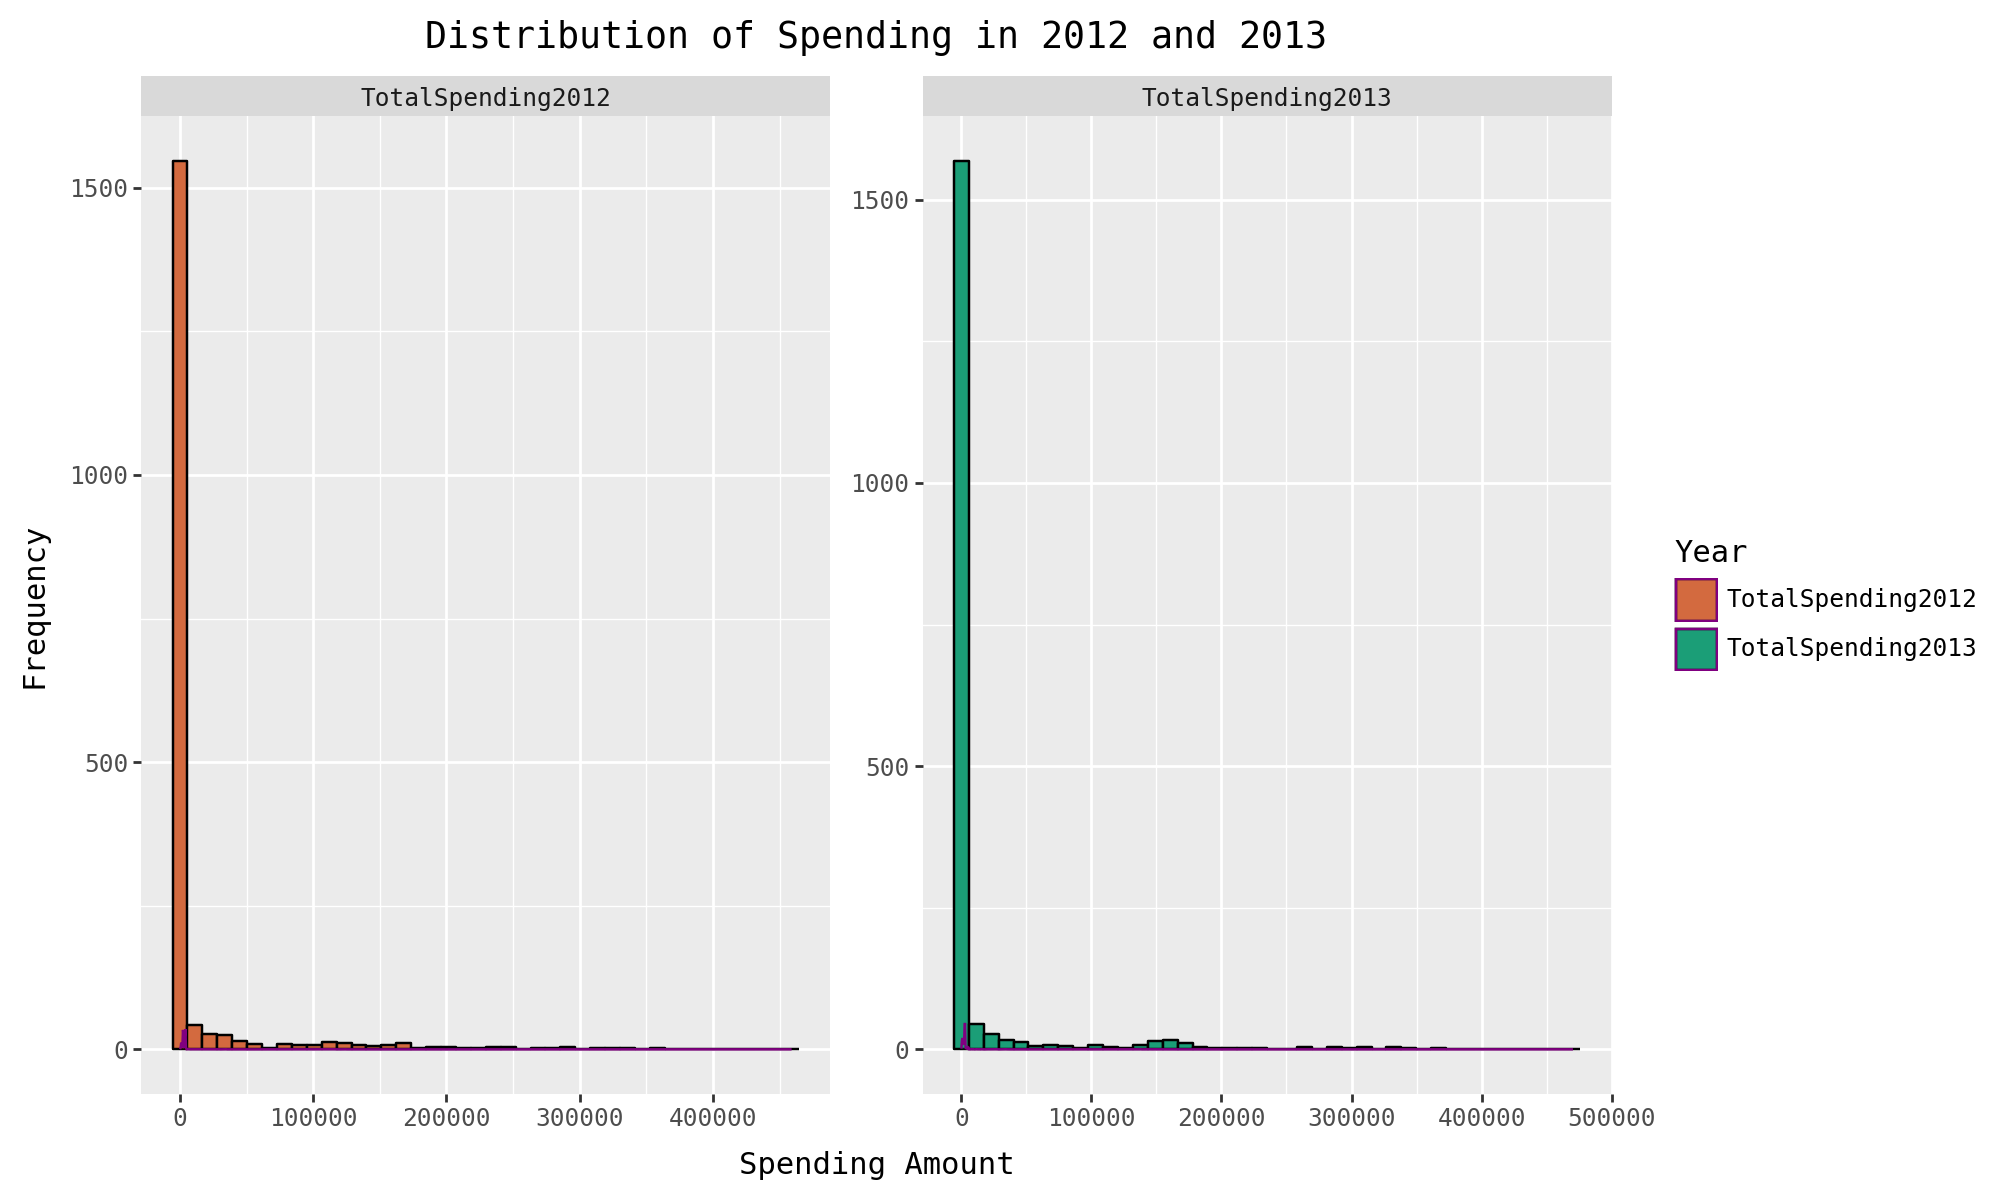

In [757]:
def plot_histograms(dataframe):
    """
    Plot histograms for specified columns of the dataset to visualize their distributions.
    """

    # Reshape the DataFrame for histograms
    melted_df = dataframe.melt(
        id_vars='CustomerID', 
        value_vars=['TotalSpending2012', 'TotalSpending2013'], 
        var_name='Year', 
        value_name='Spending'
    )
    
    # Create the plot
    plot = (
        ggplot(melted_df, aes(x='Spending', fill='Year'))
        + geom_histogram(aes(y=after_stat('count')), bins=42, color='black')
        + geom_density(aes(y=after_stat('count*42')), color='purple', alpha=0.2)
        + facet_wrap('~Year', scales='free', ncol=2)
        + scale_fill_manual(values=['#D36A3F', '#1B9E77'])
        + labs(title='Distribution of Spending in 2012 and 2013', x='Spending Amount', y='Frequency')
        + theme(figure_size=(10, 6))
    )
    
    return plot


def normality_test(dataset, column_names):
    """
    Perform D'Agostino and Pearson's test for normality on a specified column of the dataset.
    """
    for column_name in column_names:
        # Check if the column exists in the dataset
        if column_name not in dataset.columns:
            print(f"Column '{column_name}' not found in the dataset.")
            continue
        
        # Extract the column data
        data = dataset[column_name]

        # Perform D'Agostino and Pearson's test
        stat, p_value = normaltest(data)
        alpha = 0.05

        # Display the results
        print(f'{column_name} : Statistics={stat}, p={p_value}')
        if p_value > alpha:
            print("Data looks Gaussian (We fail to reject H0).")
        else:
            print("Data does not appear to be Gaussian (We reject H0).\n")


# Check for normality
normality_test(customer_spending_df, ['TotalSpending2012', 'TotalSpending2013'])

# Calculating skewness - quantifies the asymmetry of the data distribution
skewness = skew(customer_spending_df['TotalSpending2012'])
statistic, p_value = skewtest(customer_spending_df['TotalSpending2012'])
print(f'Skewness: {skewness}')
print(f'Statistic: {statistic}, p-value: {p_value}')

# Visual inspection of normality
plot_histograms(customer_spending_df)

The histograms reveals that our data does not follow a normal distribution, a finding corroborated by normality tests and skewness statistics. In a normal distribution, skewness would be near zero, indicating symmetry around the mean. However, our data exhibits right skewness, suggesting that non-parametric tests may be more appropriate for subsequent statistical analyses as well as outlier cleaning.

### 3. Outlier detection and cleaning

Dataset with outliers: 1801
Dataset after dropping outliers: 1449

TotalSpending2012 : Statistics=116.35045618538928, p=5.430245393786332e-26
Data does not appear to be Gaussian (We reject H0).

TotalSpending2013 : Statistics=186.70163673276215, p=2.872464713375452e-41
Data does not appear to be Gaussian (We reject H0).

Skewnness in 2012: -0.2927153411717976
Skewnness in 2013: -0.30776996794894507


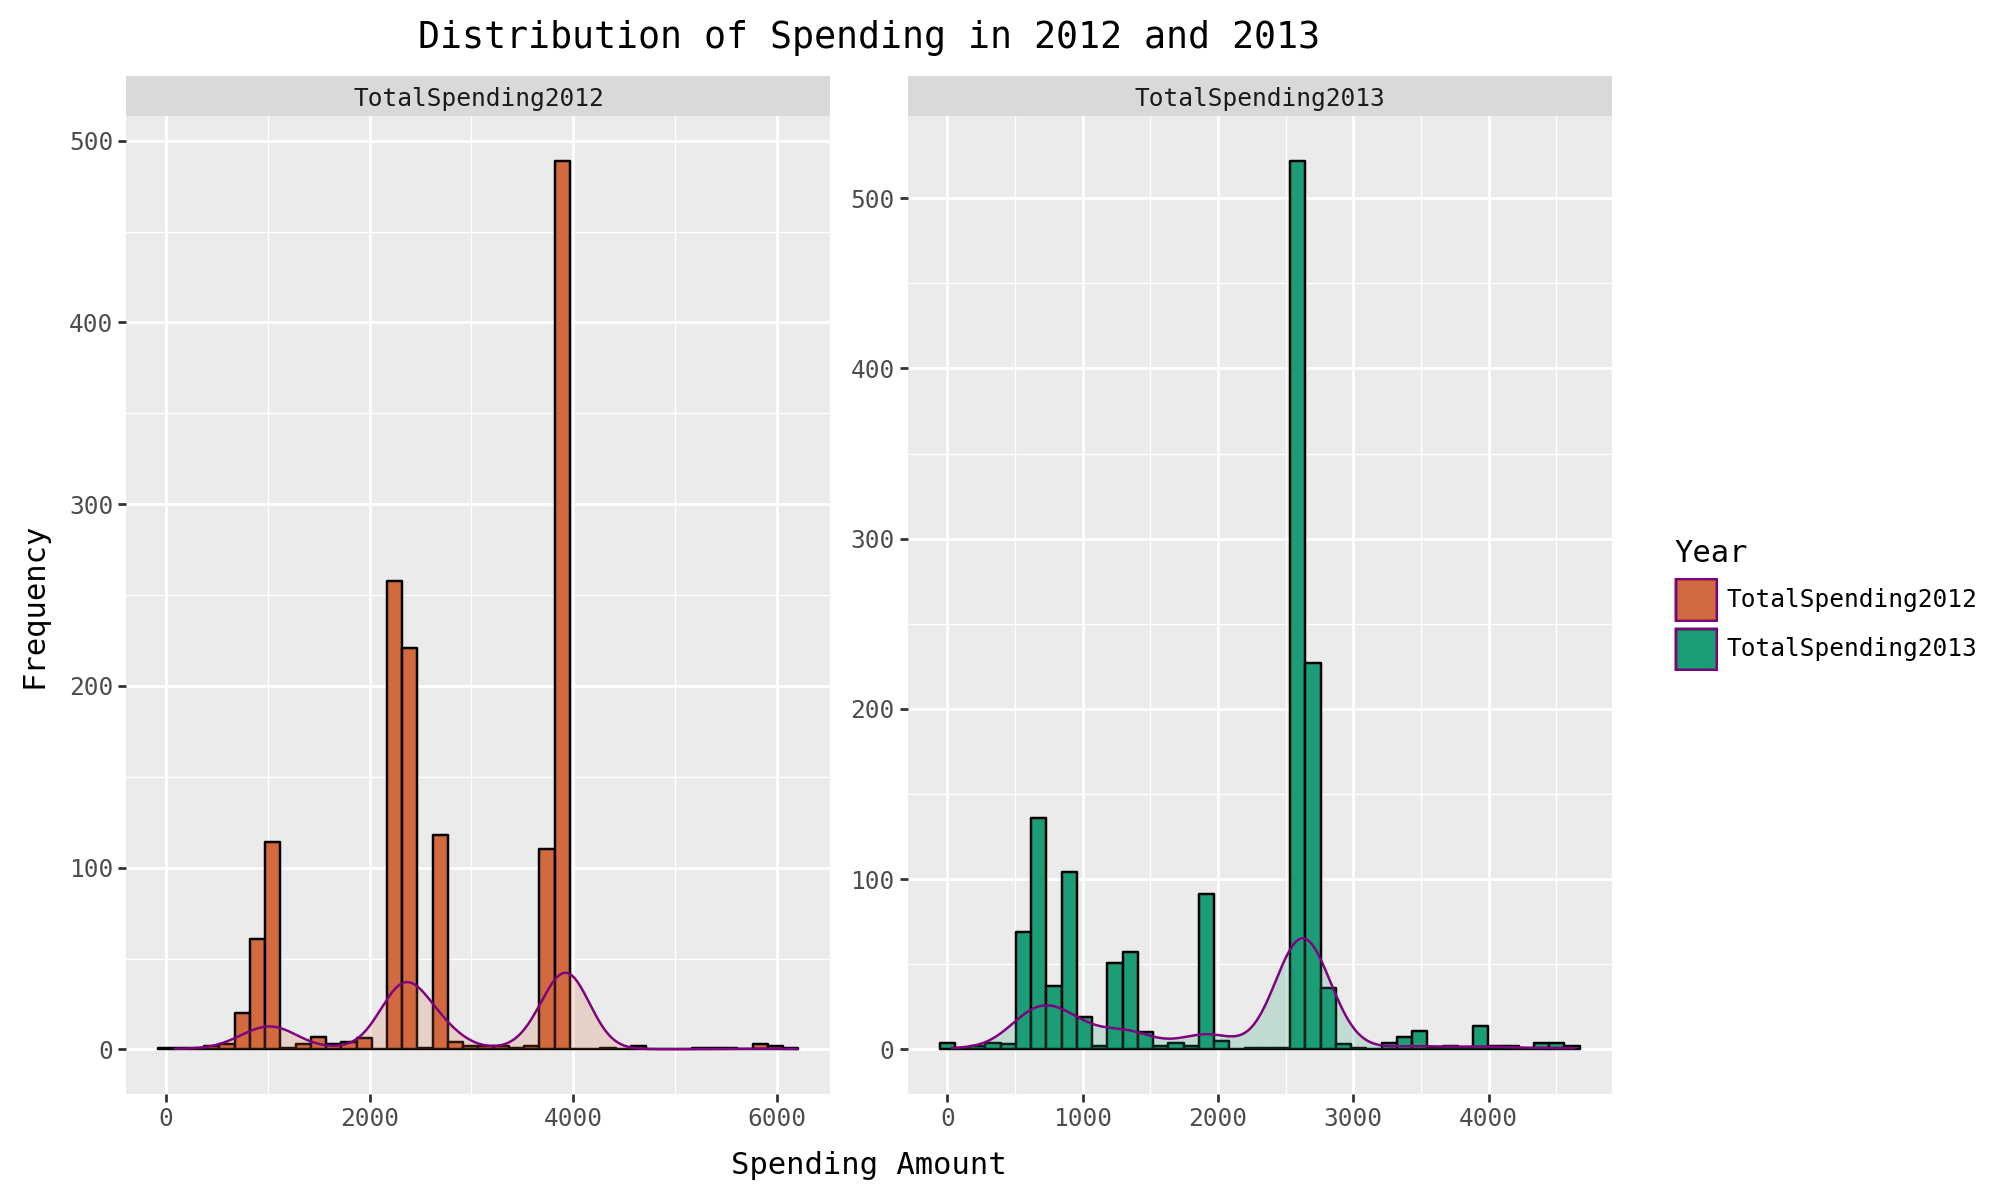

In [758]:
def remove_outliers_iqr(df, column):
    """
    Remove outliers in a DataFrame column using the IQR-method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter the dataframe
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df


# Filter out the outliers in order to make the sample more representative
df_cleaned_data = remove_outliers_iqr(customer_spending_df, 'TotalSpending2012')
df_cleaned_data = remove_outliers_iqr(df_cleaned_data, 'TotalSpending2013')

# Check how many rows that were dropped
print(f'Dataset with outliers: {len(customer_spending_df)}')
print(f'Dataset after dropping outliers: {len(df_cleaned_data)}\n')

# Check for normality
normality_test(df_cleaned_data, ['TotalSpending2012', 'TotalSpending2013'])
skewness_2012 = skew(df_cleaned_data['TotalSpending2012'])
skewness_2013 = skew(df_cleaned_data['TotalSpending2013'])
print(f'Skewnness in 2012: {skewness_2012}')
print(f'Skewnness in 2013: {skewness_2013}')

# The distribution of data after cleaning
plot_histograms(df_cleaned_data)

After cleaning the data, 352 data points were removed as outliers using the Interquartile Range (IQR) method. This decision was based on the observation that some customers had extremely high spending amounts, with figures reaching up to $470,230, which are not representative of the typical customer. The IQR method is effective in identifying such outliers, especially in skewed data distributions, as it is less sensitive to extreme values. Post-removal, the histogram of the data indicates that while the distribution is not perfectly normal, it has become more symmetric (the skewness value -0.3 is closer to zero than before cleaning the data). This improvement justifies focusing on the median as the central tendency measure instead of the mean, due to the median's robustness to outliers. The median provides a more reliable central value in the presence of skewed data or extreme values. 

#### 3.1 Add new columns in dataframe for statistical analysis

In [759]:
# Calculate the difference between 2012 and 2013
df_cleaned_data['Difference'] = df_cleaned_data['TotalSpending2013'] - df_cleaned_data['TotalSpending2012']

# Convert the differences to a categorical variable for bar plot
df_cleaned_data['diff_cat'] = df_cleaned_data['Difference'].astype('float')

# Determine the direction of the difference
df_cleaned_data['Direction'] = df_cleaned_data['Difference'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No change'))

# Calculate the absolute difference
df_cleaned_data['Magnitude'] = df_cleaned_data['Difference'].abs()

# Calculate the median of difference
median_diff = df_cleaned_data['Difference'].median()

#### 4. Plot the paired data

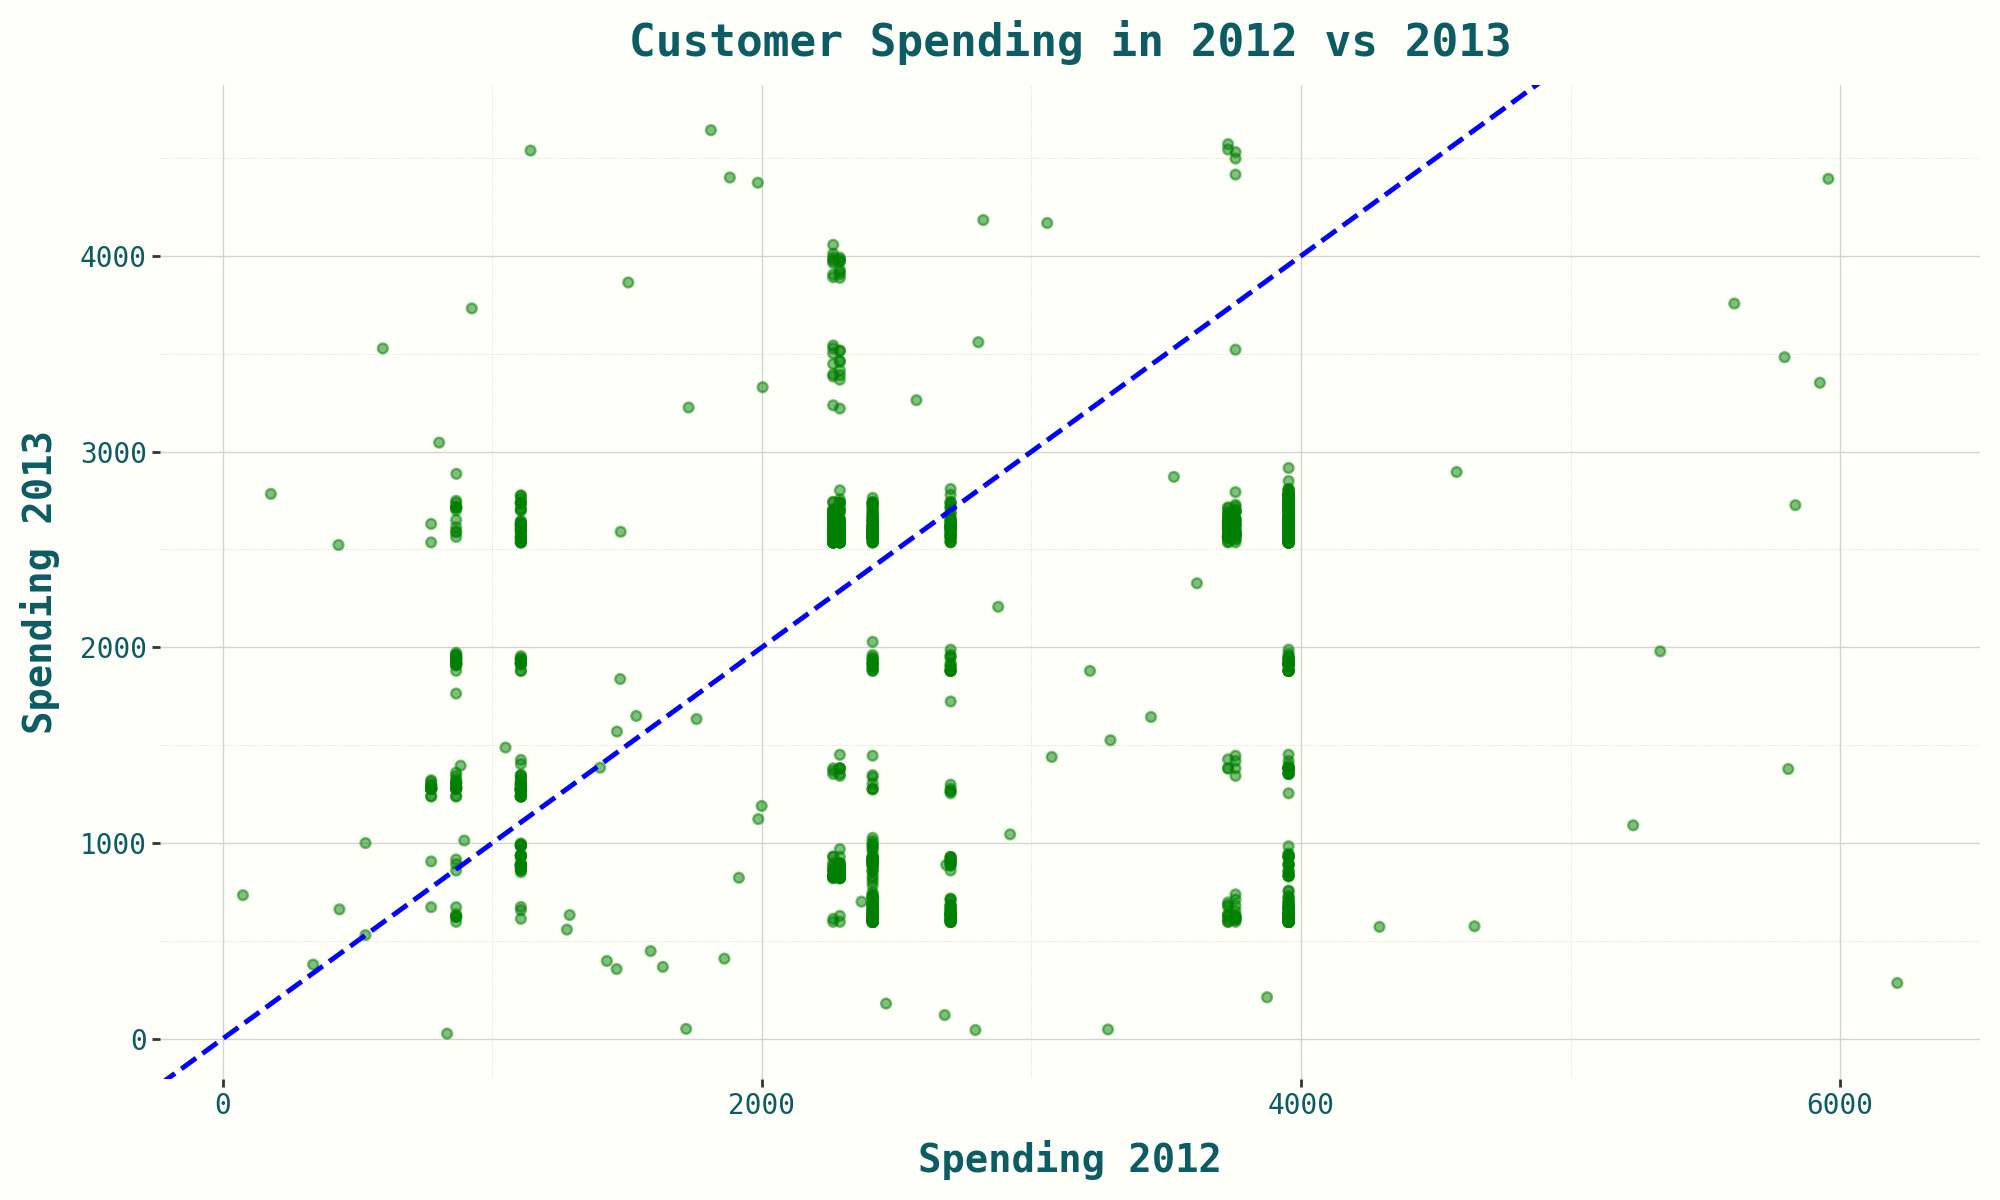

In [760]:
# Scatter plot of customer pending data for 2012 and 2013
scatter_plot = (
    ggplot(df_cleaned_data, aes(x='TotalSpending2012', y='TotalSpending2013')) 
    + geom_jitter(width=0.05, height=0.05, color='green', alpha=0.5) 
    + geom_abline(slope=1, intercept=0, color='blue', linetype='dashed', size=1)
    + labs(
        title='Customer Spending in 2012 vs 2013',
        x='Spending 2012',
        y='Spending 2013'
    )
    + bengtegard_theme()
)

scatter_plot

In the scatter plot above, each point represents a customer's spending in 2012 (x-axis) and 2013 (y-axis.). The blue line serves as a reference where spending in 2012 equals spending in 2013. Therefore, points that fall above and to the left ot the blue line indicate cases for which customers increased ther spending form 2012 to 2013. Visually one can note that there appears to be a larger concentration of points below the line, which suggests a trend of reduced spending from 2012 to 2013. The magnitude of decrease is the vertical distance of each point from the line, the farther below the line, the greater the decrease. However, it is hard to make any clear conclusion from this, and therefore further statistical analysis is warranted.

Skewness: 0.046866223177113885


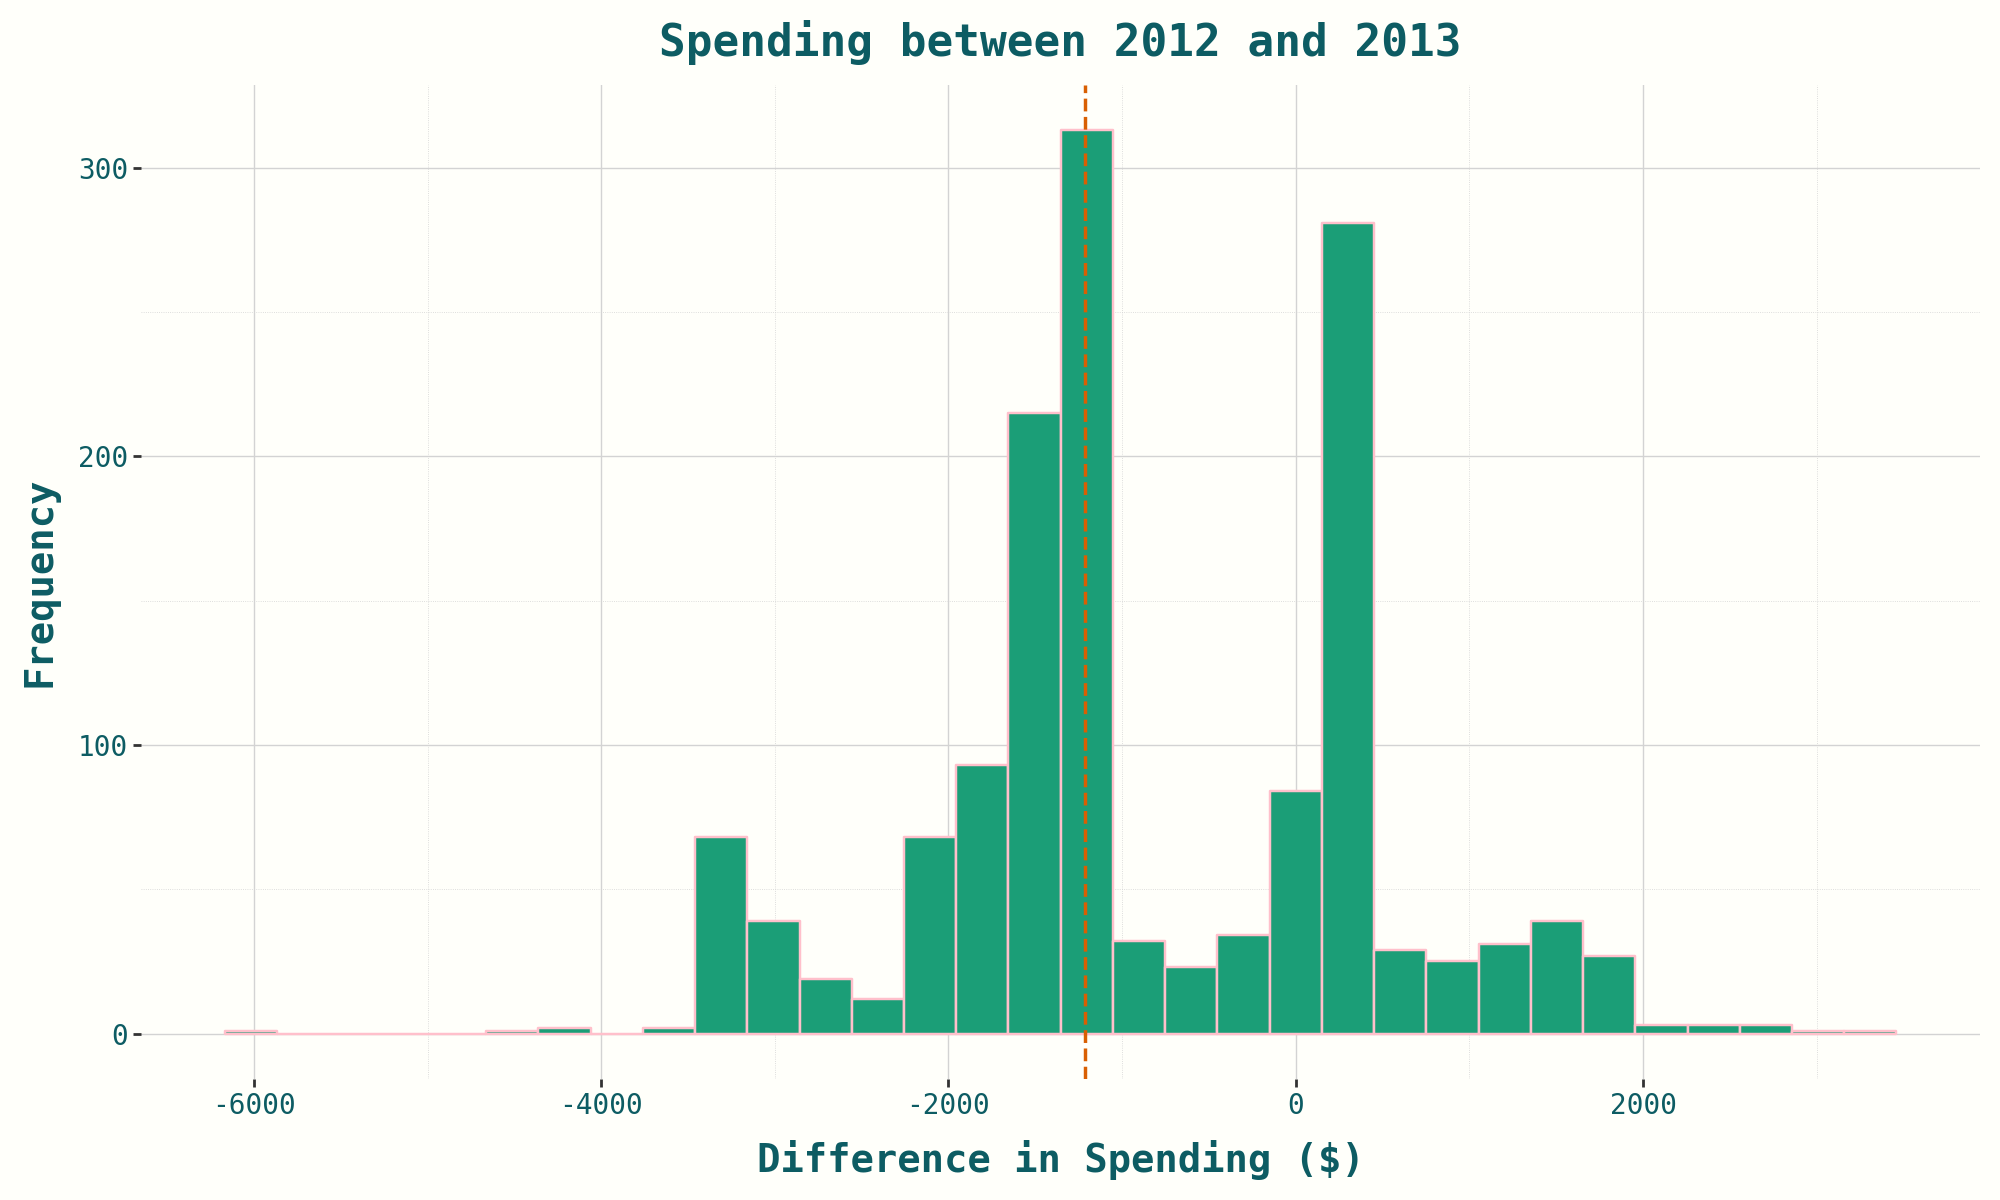

In [761]:
# Bar plot of median spending difference
diff_barplot = (
    ggplot(df_cleaned_data, aes(x='Difference'))
    + geom_histogram(bins=None, fill='#1B9E77', colour='pink')
    + geom_vline(aes(xintercept=median_diff), 
                 color='#D95F02', 
                 linetype='dashed',
                 size=0.7)
    + labs(x='Difference in Spending ($)', 
           y='Frequency',
           title='Spending between 2012 and 2013')
    + bengtegard_theme()
)
skewness_diff= skew(df_cleaned_data['Difference'])
print(f'Skewness: {skewness_diff}')

diff_barplot

The bar plot above shows a nearly symmetric, bimodal distribution of median differences in spending between 2012 and 2013, with a higher frequency of negative differences. This observation aligns with the scatter plot, suggesting a general decrease in spending from 2012 to 2013. Note that the dotted red line is the median difference for 2012 and 2013. To determine whether this difference is statistically significant, I have choosen to perform the Wilcoxon-signed-rank test, which is a non-parametric test suitable for paired data that doesn't assume normality. The skewness value of 0.046 suggests that the data is nearly symmetric, making it appropriate for the Wilcoxon Signed-Rank test which assumes that the distribution of paired differences is symmetric.

#### 5. Descriptive statistics, Confidence Interval and Significance test

In [762]:
# Descriptive statistics
descriptive_stats = df_cleaned_data[['TotalSpending2012', 'TotalSpending2013']].describe()

# Perform non-parametric significance test Wilcoxon Signed-Rank (two-tailed)
result = pg.wilcoxon(df_cleaned_data['TotalSpending2012'], 
                     df_cleaned_data['TotalSpending2013'], alternative='two-sided')

# Extract values from the result dataframe
stat = result['W-val'].values[0]
p_value = result['p-val'].values[0]
effect_size = result['RBC'].values[0]


# Bootstrapping for calculating the Confidence Interval
def bootstrap_ci_median_diff(data_diff, n_iterations=10000, alpha=0.05):
    """
    Estimate the confidence interval for the median difference between two paired samples using bootstrapping.
    """
    # Initialize an array to store the bootstrap sample medians
    median_differences = np.zeros(n_iterations)
    
    # Perform bootstrapping
    for i in range(n_iterations):
        # Resample with replacement
        resampled_differences = np.random.choice(data_diff, size=len(data_diff), replace=True)
        # Store the difference in medians
        median_differences[i] = np.median(resampled_differences)
    
    # Calculate 95% confidence interval
    ci_lower = np.percentile(median_differences, 100 * alpha / 2)
    ci_upper = np.percentile(median_differences, 100 * (1 - alpha / 2))

    return [ci_lower, ci_upper, median_differences]


ci_lower, ci_upper, median_differences = bootstrap_ci_median_diff(df_cleaned_data['Difference'])

# Print the results
print(descriptive_stats)
print(f'Median difference in spending: {median_diff:.1f}')
print(f'95% Confidence Interval for the Median Difference: ({ci_lower:.1f}, {ci_upper:.1f})')
print(f'Wilcoxon Signed-Rank Statistic: {stat:.1f}')
print(f'P-value: {p_value:.5f}')
print(f'Effect size: {effect_size:.1f}') 

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: Significant difference in customer spending between 2012 and 2013.')
else:
    print('Fail to reject the null hypothesis: No significant difference in customer spending between 2012 and 2013.')


       TotalSpending2012  TotalSpending2013
count        1449.000000        1449.000000
mean         2849.476872        2016.410751
std          1070.468374         905.956589
min            74.097200          25.386800
25%          2288.918700         973.991200
50%          2699.901800        2563.589000
75%          3953.988400        2628.739800
max          6212.405600        4642.532600
Median difference in spending: -1211.1
95% Confidence Interval for the Median Difference: (-1218.1, -1168.5)
Wilcoxon Signed-Rank Statistic: 200582.0
P-value: 0.00000
Effect size: 0.6
Reject the null hypothesis: Significant difference in customer spending between 2012 and 2013.


**Statistical Summary:**

The analysis of customer spending between 2012 and 2013 reveals a significant decrease in median spending, with a median difference of $-1,211.1. The 95% confidence interval for this median difference ranges from -1,218.1 to -1,169.1, indicating that the true median difference is likely to fall within this range. The Wilcoxon Signed-Rank Statistic is 200,582.0, and the P-value is 0.00000, suggesting a statistically significant difference in spending between the two years. The effect size is 0.6, which is considered a large effect, indicating a substantial change in spending behavior. Therefore, we reject the null hypothesis and conclude that there is a significant difference in sales between 2012 and 2013.

**Key Insight:**

* The analysis indicates a statistically significant decline in median customer spending from 2012 to 2013, suggesting that the marketing campaigns implemented in 2013 may not have achieved their intended objectives. This finding necessitates a comprehensive evaluation to identify potential factors contributing to this downturn.

**Considerations for Further Analysis:**
* **Customer Segmentation:** The current analysis focuses solely on existing customers, excluding new customers acquired in 2013. This approach was intended to assess the effectiveness of marketing efforts on the same customer base over time, aiming to control for inherent spending behavior variability. However, it's crucial to evaluate the impact on new customers to gain a complete understanding of the campaigns' reach and effectiveness.
  
* **External Factors:** Consideration should be given to external influences during 2013 that may have affected customer spending, such as economic conditions or changes in consumer preferences.

* **Qualitative Research:** Conduct surveys or focus groups to gather qualitative insights into customer perceptions and experiences, which may shed light on the reasons behind decreased spending.


### **Executive Summary**

The analysis reveals a decline in median customer spending from 2012 to 2013, indicating underperformance of the year’s marketing campaigns and the need for further evaluation. **Clothing** is the most cost-efficient product category, while **Mountain-200 Black/Silver** is the most profitable product line, with the Black, 38 variant contributing $679,003 in profit.

Regionally, **Europe** leads in revenue with improving profit margins by 2014, **North America** faces profitability challenges despite high revenue, and **Pacific** excels in profit margins, suggesting strong cost management. Country-level data highlights profitability strengths in **Australia** (32.5%) and **Germany** (21.8%), contrasting with weaker margins in the **United States** (4.2%) and **Canada** (3.0%).

Order volume surged from 43 (May 2011) to a peak of 2,400 (May 2014) before declining to 939, reflecting potential market saturation. Revenue trends show steady growth until a February 2014 dip, followed by a record $8.1M in March 2014.

**Recommendations**

* Prioritize the **Mountain-200 Black/Silver series** to maximize profits.
  
* Address cost inefficiencies in **North America**.
  
* Capitalize on the **Pacific region's** high margins for growth.
  
* Investigate the 2013 spending decline to inform future campaigns.


### **Självutvärdering**


**1. Utmaningar du haft under arbetet samt hur du har hanterat dem.**

En tidig utmaning var att försöka begräna omfånget i sitt arbete, blev snabbt för ivrig och kom in på en del komplicerade tidsserie analyser som jag efter ett tag insåg blev alldeles för komplext. Valde därför att försöka öva mig i att utforska databasen genom SQL och sedan med hjälp av utforskande visualiseringar skapa en riktning. När man väl har ställt en fråga uppkommer oftast ännu fler frågor upp, det är därför inte alltid lätt att veta vilken väg man ska välja. Less is is more är väl i sådana fall en lärdom. Dessutom la jag nog ner lite väl mycket tid på själva estetiken av mina data visualiseringar, men det är något jag tycker är roligt så why not. 

**2. Vilket betyg du anser du skall ha och varför.**

Upplever att jag förtjänar ett VG eftersom jag har lagt ner mycket tid på att programmera, skapa återanvändbara funktioner samt tydliga och pedagogiska visualiseringar. Vidare har jag försökt beskriva upplägget på mitt projekt, det vill säga vad jag har gjort innan, före och efter för att läsaren bättre ska förstå mina beslut. En stor tid har också spenderats på trådar från Stackoverflow, Youtube och diverse andra matnyttiga hemsidor för att förstå och motivera min beslut gällande mina statistiska analyser.

**3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.**

Begräna dina frågeställningar. Bättre att göra någonting koncist och noggrant än att fläska på med massa olika analyser. Blir ett mer trovärdigt intryck och lättare för en själv att faktiskt förstå på djupet vad analysen ger för ny information. Försök bli vän med en statistiker så kanske man slipper lite huvudbry. 

